# Semi_defect_finder — Ensemble (Soft Voting)

> **Dataset**: https://www.kaggle.com/datasets/programmer3/semiconductor-sensor-data-for-predictive-quality
>
> **GitHub**: https://github.com/yrtny70127/Semiconductor_Quality_Prospect.git

## 도메인
**반도체 제조 공정** — 제품 엔티티 수율 유형 예측

## 비즈니스 맥락

복잡한 최신 반도체 제조 공정은 센서 및 공정 측정 지점에서 수집된 신호/변수 모니터링을 통해 지속적으로 감시됩니다.</br>
그러나 이러한 신호 중 일부가 특정 모니터링 시스템에서 동일하게 가치 있는 것은 아닙니다.

- 측정된 신호에는 **유용한 정보, 관련 없는 정보, 그리고 노이즈**가 혼합되어 있음
- 엔지니어는 실제로 필요한 것보다 훨씬 많은 신호를 보유
- **피처 선택**을 통해 가장 관련성이 높은 신호를 식별 → 수율 변동의 주요 요인 파악
- 이를 통해 공정 처리량 증가, 학습 시간 단축, 단위 생산 비용 절감 가능

## 목표

- 특정 공정 요소의 **합격/불합격(Pass/Fail) 수율을 예측**하는 분류기 구축
- 모델 구축에 모든 피처가 필요한지 분석

## 데이터셋

| 항목 | 내용 |
|------|------|
| **파일** | `uci-secom.csv` (1,567 × 592) |
| **샘플** | 1,567개 (각각 하나의 생산 요소) |
| **피처** | 591개 센서 측정값 |
| **타겟** | Pass/Fail (`-1` = Pass, `1` = Fail) |
| **불균형** | Fail 비율 ~6.6% (1:14) |
| **타임스탬프** | 해당 테스트 시점 |

## 전략

**1. 환경 설정** — 라이브러리 import, 경로 설정

**2. 데이터 로드** — `uci-secom.csv` 읽기, Shape · NaN · 타겟 분포 확인

**3. 전처리**
- Time 컬럼 제거 → 분산 0 컬럼 제거 → |상관계수| ≥ 0.7 제거 → 라벨 인코딩(Pass/Fail → 0/1)
- 결측률 ≥ 50% 컬럼 제거 → SimpleImputer(median) 결측치 대치

**4. EDA**
- 타겟 분포 확인, PCA / t-SNE 시각화, Target Correlation Top 20 + 박스플롯 · 히스토그램

**5. 분할 & 피처 선택**
- Train 70% / Valid 15% / Test 15% (Stratified)
- ANOVA F-test Top 20 (Train-only fit → Valid/Test 동일 적용)

**6. 모델링**
- 개별 모델 베이스라인 (Baseline, threshold=0.5) → 5개 모델 기본 성능 확인
- 3종 샘플링 (Baseline / Under / SMOTE) × 5개 모델 = **15개 조합** Recall · Specificity · BalAcc 비교

**7. 앙상블**
- Top 3 모델 선택: 역할 분담 + 반대쪽 하한 필터(≥ 0.3)
- Soft Voting: 26가지 가중치 × 91 threshold → Valid BalAcc 최적화

**8. 검증**
- Multi-Seed (10 seeds) 전체 파이프라인 독립 반복
- Valid-Test gap + 모델 선택 빈도로 안정성 확인

## 1. 환경 설정

In [27]:
# =========================================
# Imports
# =========================================
import os
import warnings
from pathlib import Path
from collections import OrderedDict, Counter

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.base import clone

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [28]:
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)

In [29]:
# 김태훈
os.chdir("/home/tae-hun-kim/바탕화면/AI모델개발/Semiconductor_Quality_Prospect")
print(f"cwd: {os.getcwd()} | data: {os.path.exists('SECOM/uci-secom.csv')}")

cwd: /home/tae-hun-kim/바탕화면/AI모델개발/Semiconductor_Quality_Prospect | data: True


In [30]:
# #최정빈
# os.chdir(r"C:/Users/0726b/Semiconductor_Quality_Prospect")  
# print("cwd:", os.getcwd())
# print("exists:", os.path.exists("SECOM/uci-secom.csv"))

## 2. 데이터 로드

In [31]:
# =========================================
# 2. 데이터 로드 & 기본 확인
# =========================================

# 프로젝트 루트(.git) 탐색
root = Path.cwd()
while root != root.parent and not (root / ".git").exists():
    root = root.parent

csv_path = root / "SECOM" / "uci-secom.csv"
df = pd.read_csv(csv_path)

print(f"  Shape   : {df.shape[0]:,} rows × {df.shape[1]} cols")
print(f"  NaN     : {df.isna().sum().sum():,} cells ({df.isna().mean().mean():.1%})")
print(f"  Target  : {df['Pass/Fail'].value_counts().to_dict()}")

df.head()

  Shape   : 1,567 rows × 592 cols
  NaN     : 41,951 cells (4.5%)
  Target  : {-1: 1463, 1: 104}


Time         0         1         2         3      4  \
0  2008-07-19 11:55:00 3030.9300 2564.0000 2187.7333 1411.1265 1.3602   
1  2008-07-19 12:32:00 3095.7800 2465.1400 2230.4222 1463.6606 0.8294   
2  2008-07-19 13:17:00 2932.6100 2559.9400 2186.4111 1698.0172 1.5102   
3  2008-07-19 14:43:00 2988.7200 2479.9000 2199.0333  909.7926 1.3204   
4  2008-07-19 15:22:00 3032.2400 2502.8700 2233.3667 1326.5200 1.5334   

         5        6      7      8  ...      581    582    583    584     585  \
0 100.0000  97.6133 0.1242 1.5005  ...      NaN 0.5005 0.0118 0.0035  2.3630   
1 100.0000 102.3433 0.1247 1.4966  ... 208.2045 0.5019 0.0223 0.0055  4.4447   
2 100.0000  95.4878 0.1241 1.4436  ...  82.8602 0.4958 0.0157 0.0039  3.1745   
3 100.0000 104.2367 0.1217 1.4882  ...  73.8432 0.4990 0.0103 0.0025  2.0544   
4 100.0000 100.3967 0.1235 1.5031  ...      NaN 0.4800 0.4766 0.1045 99.3032   

     586    587    588      589  Pass/Fail  
0    NaN    NaN    NaN      NaN         -1  
1 0.0096 0.0201 0.0060 208.2045         -1  
2 0.0584 0.0484 0.0148  82.8602          1  
3 0.0202 0.0149 0.0044  73.8432         -1  
4 0.0202 0.0149 0.0044  73.8432         -1  

[5 rows x 592 columns]

## 3. 전처리 (Feature Engineering)
> 불필요한 피처 제거 → 결측치 처리 → 라벨 인코딩

### 3-1. Time 컬럼 제거 + 상관행렬 히트맵

  Time 컬럼 제거 완료 → 591 cols


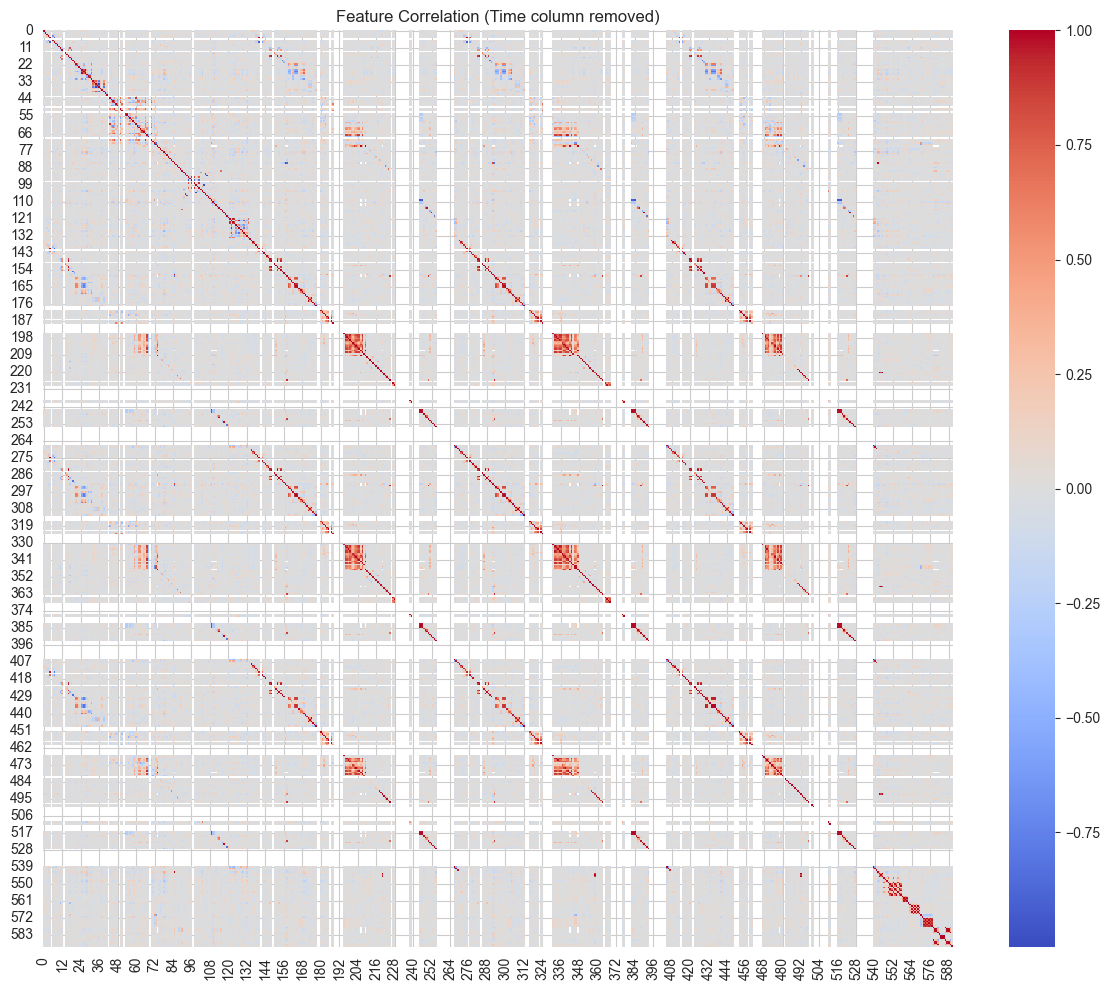

0         1         2         3      4        5        6      7  \
0 3030.9300 2564.0000 2187.7333 1411.1265 1.3602 100.0000  97.6133 0.1242   
1 3095.7800 2465.1400 2230.4222 1463.6606 0.8294 100.0000 102.3433 0.1247   
2 2932.6100 2559.9400 2186.4111 1698.0172 1.5102 100.0000  95.4878 0.1241   
3 2988.7200 2479.9000 2199.0333  909.7926 1.3204 100.0000 104.2367 0.1217   
4 3032.2400 2502.8700 2233.3667 1326.5200 1.5334 100.0000 100.3967 0.1235   

       8       9  ...      581    582    583    584     585    586    587  \
0 1.5005  0.0162  ...      NaN 0.5005 0.0118 0.0035  2.3630    NaN    NaN   
1 1.4966 -0.0005  ... 208.2045 0.5019 0.0223 0.0055  4.4447 0.0096 0.0201   
2 1.4436  0.0041  ...  82.8602 0.4958 0.0157 0.0039  3.1745 0.0584 0.0484   
3 1.4882 -0.0124  ...  73.8432 0.4990 0.0103 0.0025  2.0544 0.0202 0.0149   
4 1.5031 -0.0031  ...      NaN 0.4800 0.4766 0.1045 99.3032 0.0202 0.0149   

     588      589  Pass/Fail  
0    NaN      NaN         -1  
1 0.0060 208.2045         -1  
2 0.0148  82.8602          1  
3 0.0044  73.8432         -1  
4 0.0044  73.8432         -1  

[5 rows x 591 columns]

In [32]:
# =========================================
# 3-1. Time 컬럼 제거 + 상관행렬 히트맵
# =========================================

df = df.drop(columns=["Time"], errors="ignore")
print(f"  Time 컬럼 제거 완료 → {df.shape[1]} cols")

# Numeric-only correlation
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (Time column removed)")
plt.tight_layout()
plt.show()

df.head()


### 3-2. 분산 0 컬럼 제거

  분산 0 컬럼 116개 제거 → 475 cols


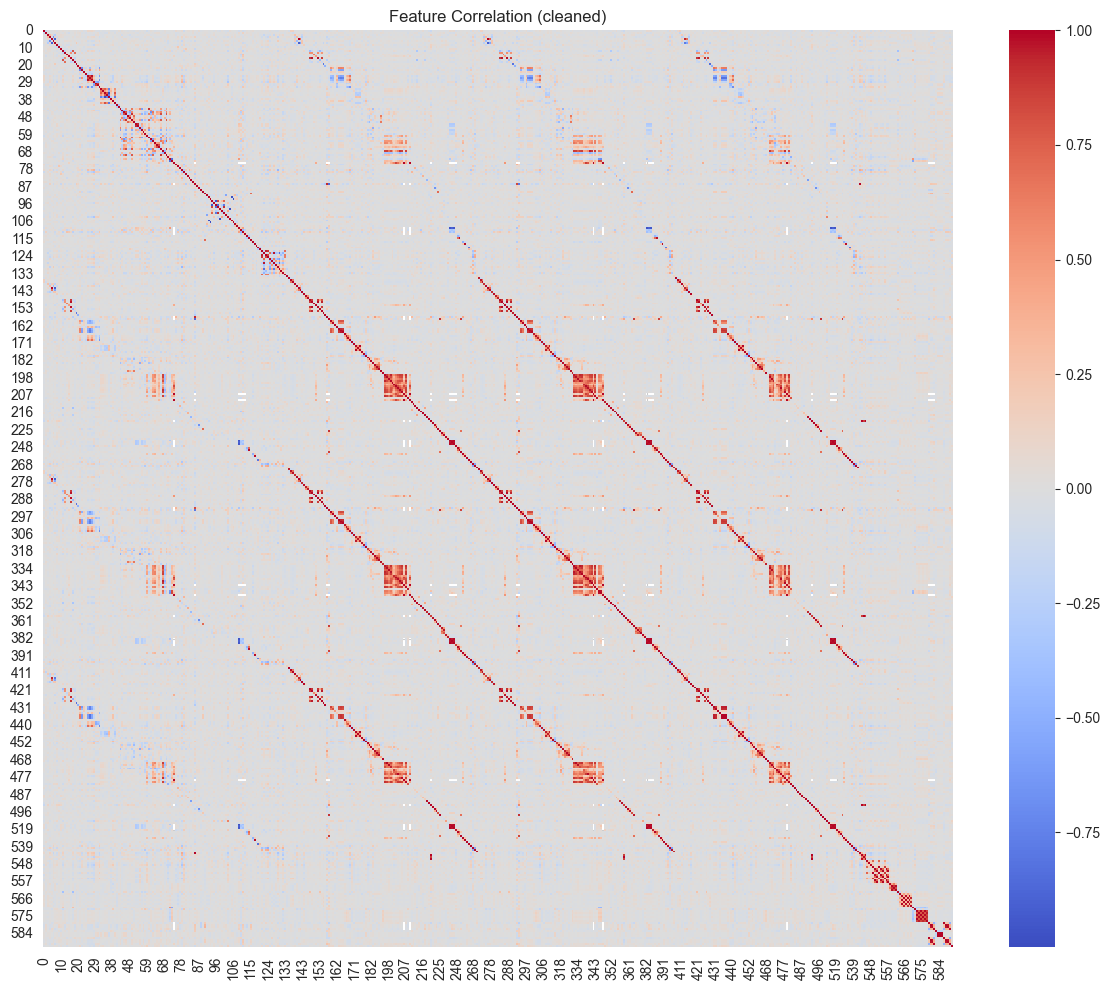

In [33]:
# df 기준
df = df.copy()

# 분산 0 컬럼 (값이 모두 동일)
zero_var_cols = df.columns[df.nunique(dropna=True) <= 1].tolist()

df = df.drop(columns=zero_var_cols)
print(f"  분산 0 컬럼 {len(zero_var_cols)}개 제거 → {df.shape[1]} cols")

# 다시 히트맵
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (cleaned)")
plt.tight_layout()
plt.show()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 475 entries, 0 to Pass/Fail
dtypes: float64(474), int64(1)
memory usage: 5.7 MB


### 3-3. 상관계수 0.7 이상 컬럼 제거

  |corr| ≥ 0.7 컬럼 272개 제거 → 203 cols


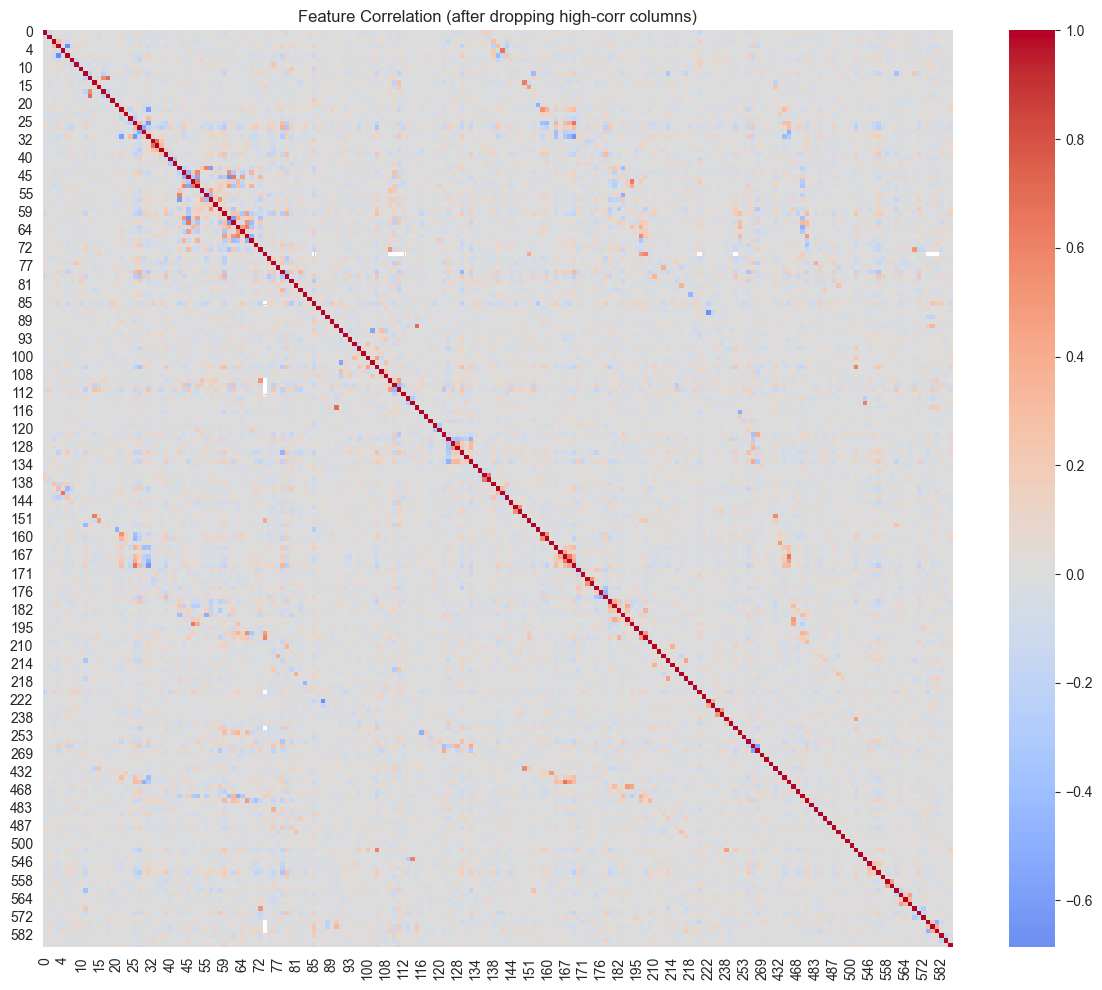

In [35]:
# 절댓값 상관계수 0.7 이상인 컬럼 제거
threshold = 0.7

# 숫자형만 상관계수
corr = df.select_dtypes(include=["number"]).corr().abs()

# 상삼각행렬만 사용 (중복 제거)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 임계치 초과 컬럼 선택
to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]

df = df.drop(columns=to_drop)
print(f"  |corr| ≥ {threshold} 컬럼 {len(to_drop)}개 제거 → {df.shape[1]} cols")

# 제거 후 히트맵
corr_after = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_after, cmap="coolwarm", center=0)
plt.title("Feature Correlation (after dropping high-corr columns)")
plt.tight_layout()
plt.show()

### 3-4. 라벨 인코딩 (Pass/Fail → 0/1)

In [36]:
# Pass/Fail을 0/1로 변환 (-1: Pass -> 0, 1: Fail -> 1)
df["Pass/Fail"] = df["Pass/Fail"].map({-1: 0, 1: 1})

df.head(20)

0         1         2         3      4        6      8       9  \
0  3030.9300 2564.0000 2187.7333 1411.1265 1.3602  97.6133 1.5005  0.0162   
1  3095.7800 2465.1400 2230.4222 1463.6606 0.8294 102.3433 1.4966 -0.0005   
2  2932.6100 2559.9400 2186.4111 1698.0172 1.5102  95.4878 1.4436  0.0041   
3  2988.7200 2479.9000 2199.0333  909.7926 1.3204 104.2367 1.4882 -0.0124   
4  3032.2400 2502.8700 2233.3667 1326.5200 1.5334 100.3967 1.5031 -0.0031   
5  2946.2500 2432.8400 2233.3667 1326.5200 1.5334 100.3967 1.5287  0.0167   
6  3030.2700 2430.1200 2230.4222 1463.6606 0.8294 102.3433 1.5816 -0.0270   
7  3058.8800 2690.1500 2248.9000 1004.4692 0.7884 106.2400 1.5153  0.0157   
8  2967.6800 2600.4700 2248.9000 1004.4692 0.7884 106.2400 1.5358  0.0111   
9  3016.1100 2428.3700 2248.9000 1004.4692 0.7884 106.2400 1.5381  0.0159   
10 2994.0500 2548.2100 2195.1222 1046.1468 1.3204 103.3400 1.5144 -0.0190   
11 2928.8400 2479.4000 2196.2111 1605.7578 0.9959  97.9156 1.4690  0.0170   
12 2920.0700 2507.4000 2195.1222 1046.1468 1.3204 103.3400 1.5310 -0.0259   
13 3051.4400 2529.2700 2184.4333  877.6266 1.4668 107.8711 1.5236 -0.0209   
14 2963.9700 2629.4800 2224.6222  947.7739 1.2924 104.8489 1.4474  0.0144   
15 2988.3100 2546.2600 2224.6222  947.7739 1.2924 104.8489 1.5465  0.0250   
16 3028.0200 2560.8700 2270.2556 1258.4558 1.3950 104.8078 1.4368  0.0150   
17 3032.7300 2517.7900 2270.2556 1258.4558 1.3950 104.8078 1.5537  0.0220   
18 3040.3400 2501.1600 2207.3889  962.5317 1.2043 104.0311 1.5481 -0.0367   
19 2988.3000 2519.0500 2208.8556 1157.7224 1.5509 107.8022 1.5362 -0.0259   

        10     11  ...    565      570    571      572    578    579      581  \
0  -0.0034 0.9455  ...    NaN 533.8500 2.1113   8.9500    NaN    NaN      NaN   
1  -0.0148 0.9627  ...    NaN 535.0164 2.4335   5.9200 0.0096 0.0201 208.2045   
2   0.0013 0.9615  ... 0.6219 535.0245 2.0293  11.2100 0.0584 0.0484  82.8602   
3  -0.0033 0.9629  ... 0.1630 530.5682 2.0253   9.3300 0.0202 0.0149  73.8432   
4  -0.0072 0.9569  ...    NaN 532.0155 2.0275   8.8300    NaN    NaN      NaN   
5   0.0055 0.9699  ... 0.1905 534.2091 2.3236   8.9100 0.0342 0.0151  44.0077   
6   0.0105 0.9591  ...    NaN 541.9036 2.4229   6.4800    NaN    NaN      NaN   
7   0.0007 0.9481  ... 0.1334 493.0054 2.2008 278.1900 0.0204 0.0194  95.0310   
8  -0.0066 0.9494  ... 0.1145 535.1818 2.2170   7.0900 0.0111 0.0124 111.6525   
9   0.0049 0.9440  ... 0.0361 533.4200 2.2598   3.5400 0.0212 0.0191  90.2294   
10  0.0013 0.9433  ... 0.1224 532.1764 1.8715   9.5699 0.0355 0.0205  57.8122   
11 -0.0154 0.9445  ... 0.0856 533.7464 2.1865   7.7400 0.0370 0.0279  75.5077   
12  0.0216 0.9595  ...    NaN 530.1800 1.9690   9.9500 0.0188 0.0098  52.2039   
13 -0.0031 0.9441  ... 0.1938 533.2464 2.2354   9.9300    NaN    NaN      NaN   
14 -0.0119 0.9582  ...    NaN 532.6446 2.2808  11.4200 0.0202 0.0289 142.9080   
15 -0.0024 0.9616  ...    NaN 536.1118 2.3120   8.5300 0.0174 0.0174 100.2745   
16 -0.0037 0.9623  ... 0.1165 537.8145 2.1113   8.4300 0.0184 0.0151  82.0989   
17 -0.0027 0.9613  ... 0.1089 531.8418 2.1849  10.2600    NaN    NaN      NaN   
18  0.0014 0.9634  ... 0.0910 532.2673 2.2820   6.0000    NaN    NaN      NaN   
19 -0.0179 0.9614  ...    NaN 534.6455 2.0642   7.8100 0.0229 0.0108  47.1586   

      582    583  Pass/Fail  
0  0.5005 0.0118          0  
1  0.5019 0.0223          0  
2  0.4958 0.0157          1  
3  0.4990 0.0103          0  
4  0.4800 0.4766          0  
5  0.4949 0.0189          0  
6  0.5010 0.0143          0  
7  0.4984 0.0106          0  
8  0.4993 0.0172          0  
9  0.4967 0.0152          0  
10 0.4925 0.0158          1  
11 0.4987 0.0427          1  
12 0.4950 0.0153          0  
13 0.5034 0.0151          0  
14 0.5077 0.0094          1  
15 0.5058 0.0078          0  
16 0.5005 0.0108          0  
17 0.5015 0.0105          0  
18 0.4948 0.0117          0  
19 0.5036 0.0169          0  

[20 rows x 203 columns]

### 3-5. 결측치 처리

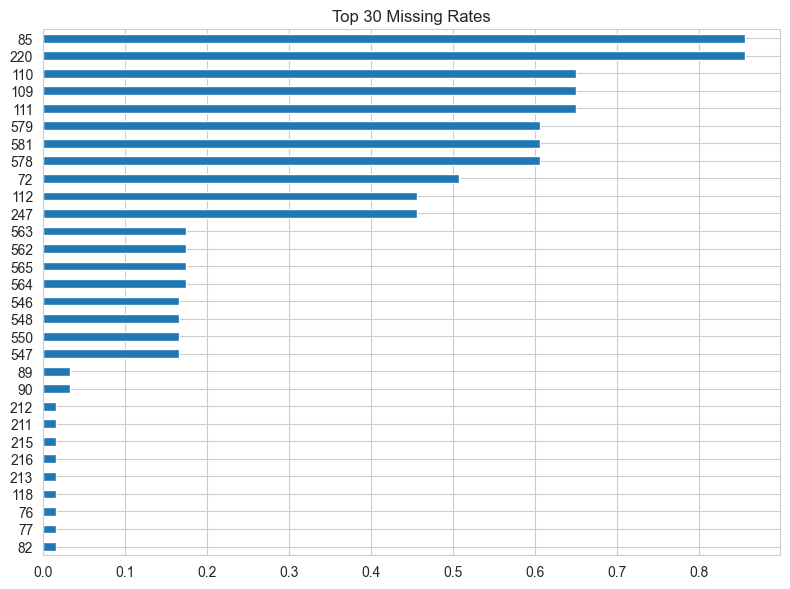

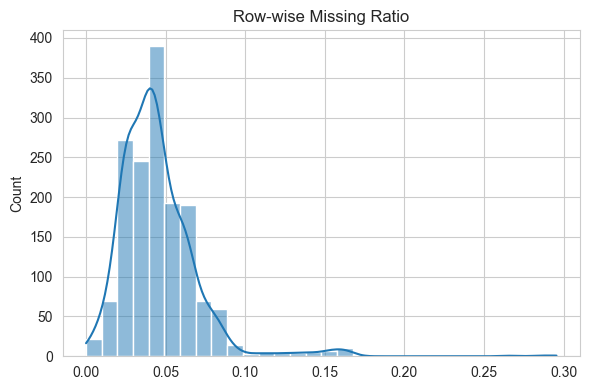

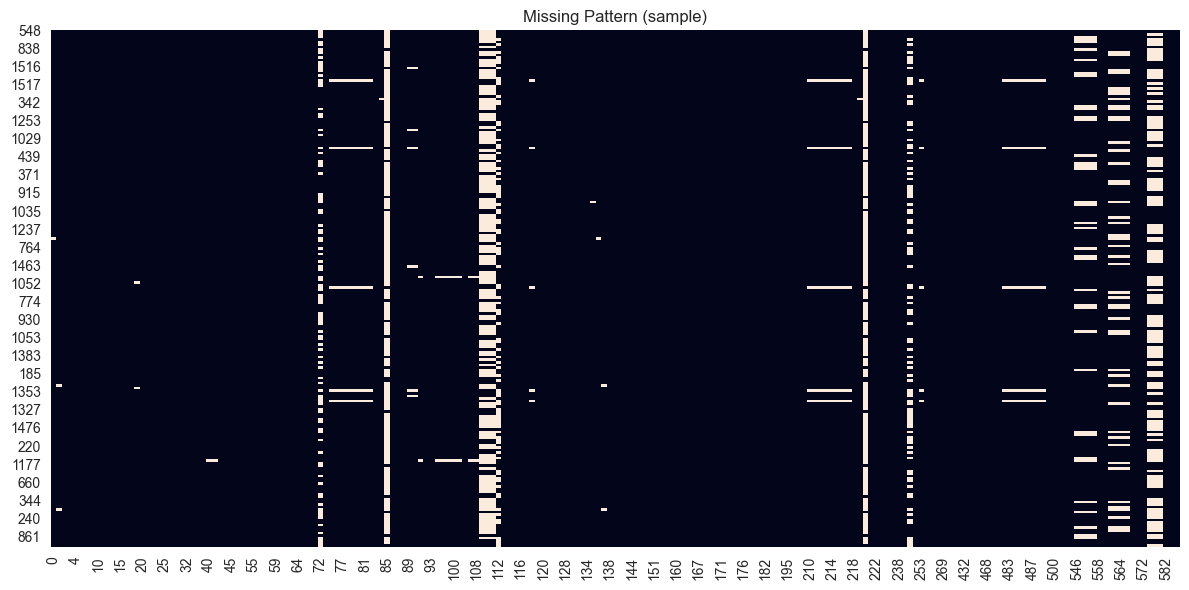

Pass/Fail      0      1
0         0.0041 0.0000
1         0.0041 0.0096
2         0.0096 0.0000
3         0.0096 0.0000
4         0.0096 0.0000
6         0.0096 0.0000
8         0.0014 0.0000
9         0.0014 0.0000
10        0.0014 0.0000
11        0.0014 0.0000

In [37]:

# 1) 컬럼별 결측률 상위 30개
missing_rate = df.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
missing_rate.head(30).plot(kind="barh")
plt.title("Top 30 Missing Rates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2) 행별 결측률 분포
row_missing = df.isna().mean(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(row_missing, bins=30, kde=True)
plt.title("Row-wise Missing Ratio")
plt.tight_layout()
plt.show()

# 3) 결측 패턴 히트맵 (샘플 200행)
sample = df.sample(min(200, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Pattern (sample)")
plt.tight_layout()
plt.show()

# 4) 타깃별 결측률 비교 (Pass/Fail 컬럼이 있을 때)
if "Pass/Fail" in df.columns:
    missing_by_target = df.groupby("Pass/Fail").apply(lambda x: x.isna().mean())
    display(missing_by_target.T.head(10))


  결측률 ≥ 50% 컬럼 9개 제거 → 194 cols


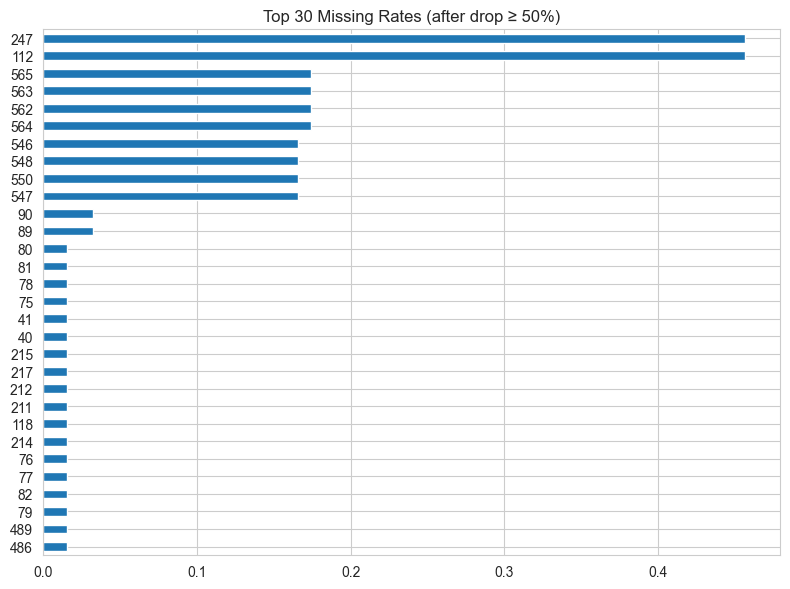

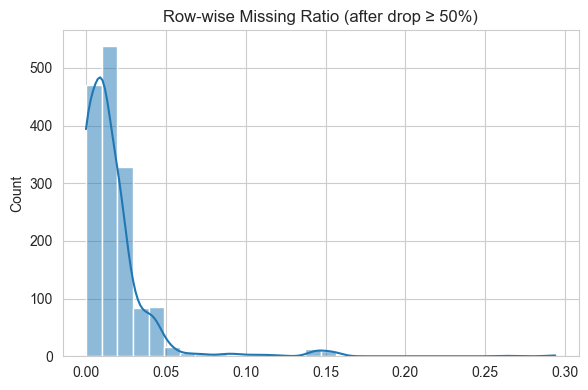

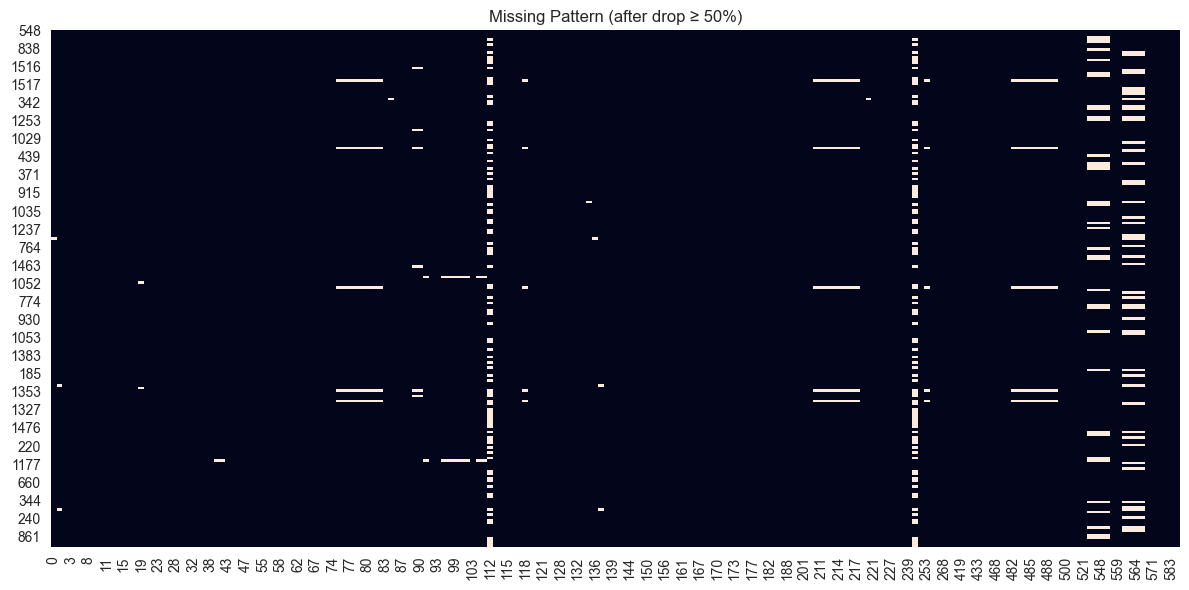

In [38]:
# 결측률 0.5 이상 컬럼 제거
threshold = 0.5
missing_rate = df.isna().mean()
drop_cols = missing_rate[missing_rate >= threshold].index.tolist()

df = df.drop(columns=drop_cols)
print(f"  결측률 ≥ {threshold:.0%} 컬럼 {len(drop_cols)}개 제거 → {df.shape[1]} cols")

# 1) 컬럼별 결측률 상위 30개 (제거 후)
missing_after = df.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
missing_after.head(30).plot(kind="barh")
plt.title("Top 30 Missing Rates (after drop ≥ 50%)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2) 행별 결측률 분포 (제거 후)
row_missing = df.isna().mean(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(row_missing, bins=30, kde=True)
plt.title("Row-wise Missing Ratio (after drop ≥ 50%)")
plt.tight_layout()
plt.show()

# 3) 결측 패턴 히트맵 (제거 후)
sample = df.sample(min(200, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Pattern (after drop ≥ 50%)")
plt.tight_layout()
plt.show()

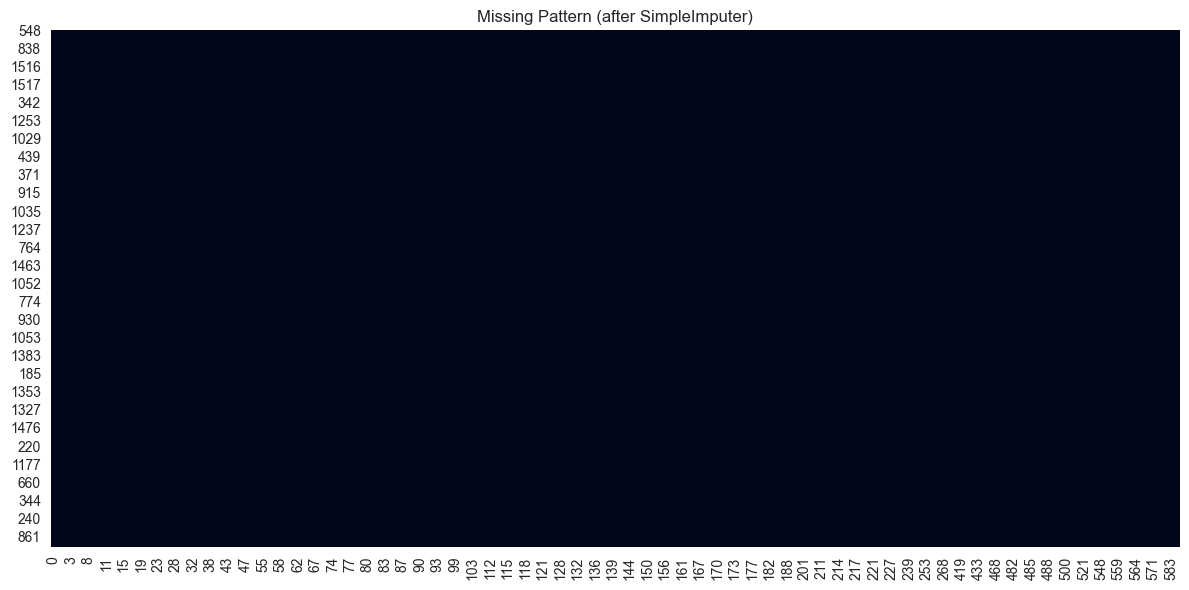

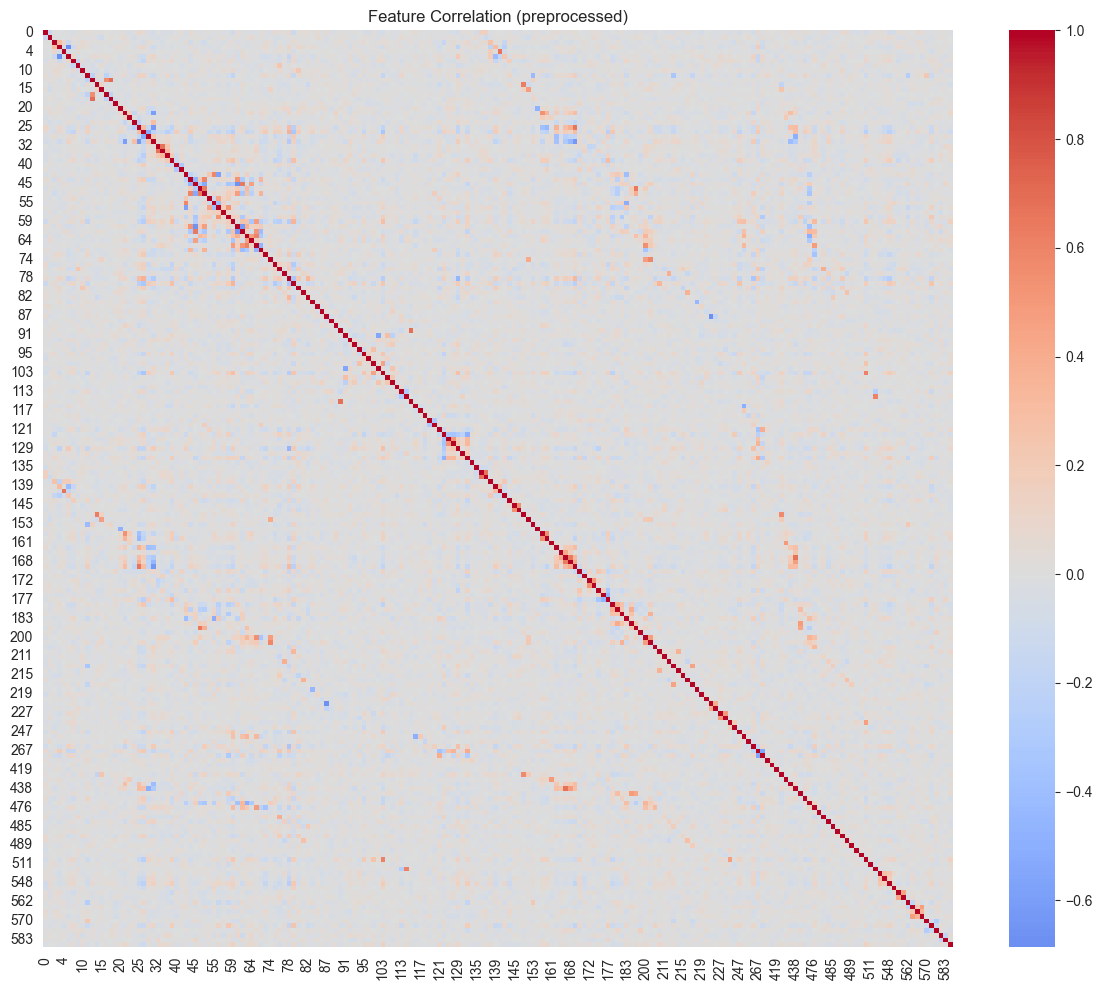

In [39]:
# SimpleImputer (median) — 결측치 중앙값 대치

target = "Pass/Fail"
X = df.drop(columns=[target])

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

df = df.copy()
df[X.columns] = X_imputed

# 결측 패턴 확인 (대치 후)
sample = df.sample(min(200, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Pattern (after SimpleImputer)")
plt.tight_layout()
plt.show()

# 전처리 완료 상관행렬 히트맵
corr_final = df.select_dtypes(include=["number"]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_final, cmap="coolwarm", center=0)
plt.title("Feature Correlation (preprocessed)")
plt.tight_layout()
plt.show()

## 4. 탐색적 데이터 분석 (EDA)
> 분포, 차원 축소, 타겟 상관관계 시각화

In [40]:
# 1) 컬럼 타입 분리
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

print(f"  Numeric {len(num_cols)} cols | Category {len(cat_cols)} cols")

# 2) 숫자형: 분산 큰 Top 10 (분포/박스플롯 추천)
num_var = df[num_cols].var().sort_values(ascending=False)
print("\n  [Variance Top 10]")
print(num_var.head(10))

# 3) 숫자형: 왜도 큰 Top 10 (로그변환 전/후 비교 추천)
num_skew = df[num_cols].skew().sort_values(ascending=False)
print("\n  [Skewness Top 10]")
print(num_skew.head(10))

# 4) 상관 높은 컬럼 쌍 Top 10 (산점도 추천)
corr = df[num_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .head(10)
)
print("\n  [High Correlation Pairs Top 10]")
print(high_corr_pairs)

# 6) 범주형: 값 개수 많은 Top 10 (막대그래프/파이 추천)
if cat_cols:
    cat_card = df[cat_cols].nunique().sort_values(ascending=False)
    print("\n  [Categorical Cardinality Top 10]")
    print(cat_card.head(10))

  Numeric 194 cols | Category 0 cols

  [Variance Top 10]
162   42905999.0744
161   17950939.2503
24     8414910.8908
23     1902415.0651
159     965225.4011
21      392415.7938
160     330000.5041
3       193456.8768
90      151949.5298
511     108637.1523
dtype: float64

  [Skewness Top 10]
74    39.5854
117   38.0060
16    37.0703
583   24.4174
251   21.5880
67    20.8247
4     19.7341
156   18.9685
89    18.6440
184   18.1753
dtype: float64

  [High Correlation Pairs Top 10]
12   18    0.6933
3    6     0.6858
90   115   0.6802
167  438   0.6750
32   33    0.6712
25   169   0.6707
4    142   0.6678
87   222   0.6661
136  137   0.6649
45   61    0.6649
dtype: float64


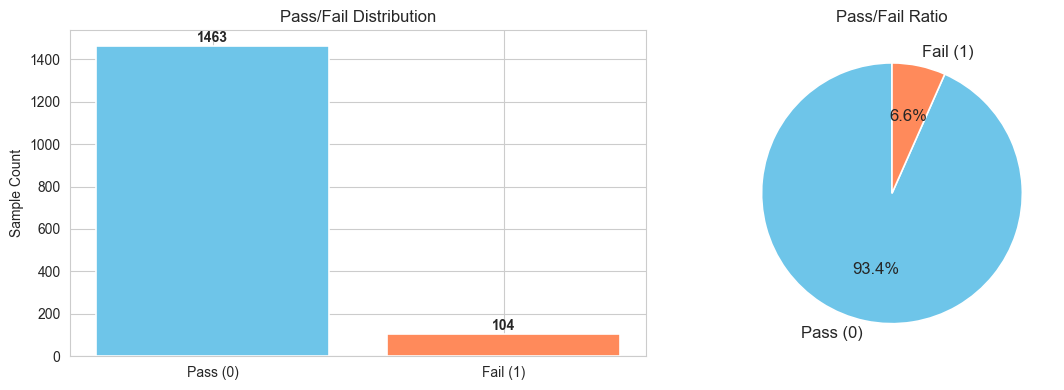

In [41]:
# =========================================
# 4. 타겟 분포 (Pass/Fail Ratio)
# =========================================
counts = df['Pass/Fail'].value_counts().sort_index()
labels = ['Pass (0)', 'Fail (1)']
colors = ['#6EC5E9', '#FF8A5B']  # 파스텔 블루/코랄

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar
axes[0].bar(labels, counts.values, color=colors, edgecolor='white', linewidth=1.2)
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 20, f'{v}', ha='center', fontweight='bold')
axes[0].set_ylabel('Sample Count')
axes[0].set_title('Pass/Fail Distribution')

# Pie
axes[1].pie(
    counts.values,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.2},
    textprops={'fontsize': 12}
)
axes[1].set_title('Pass/Fail Ratio')

plt.tight_layout()
plt.show()



In [42]:
# EDA용 데이터 준비 (결측치 대치 완료된 df 사용)
X_imputed = df.drop(columns=['Pass/Fail'])
y = df['Pass/Fail']

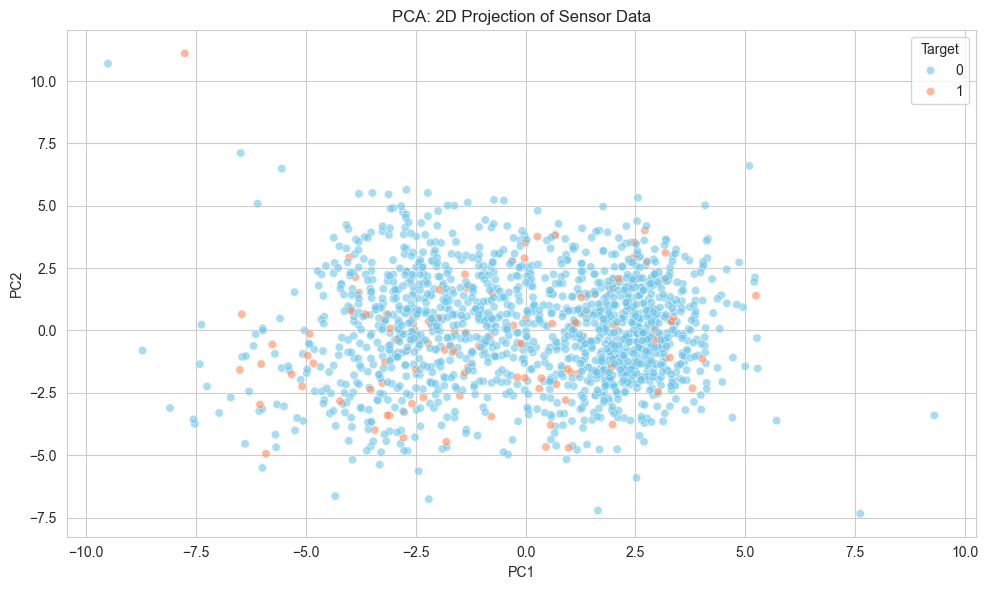

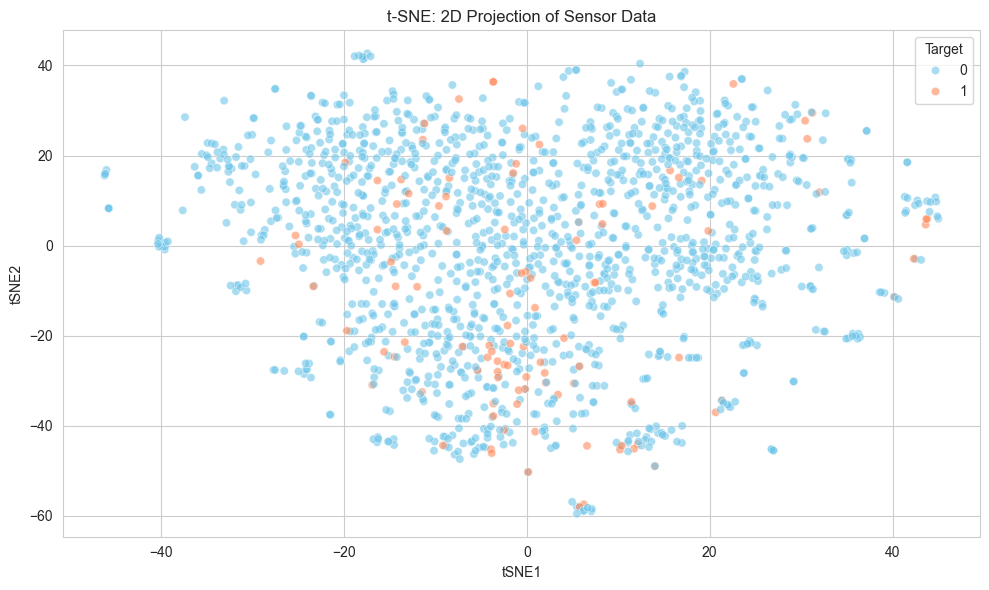

In [43]:
# PCA + t-SNE 시각화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = y.values

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
tsne_df['Target'] = y.values

palette = {0: '#6EC5E9', 1: '#FF8A5B'}

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Target',
                alpha=0.6, palette=palette)
plt.title('PCA: 2D Projection of Sensor Data')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Target',
                alpha=0.6, palette=palette)
plt.title('t-SNE: 2D Projection of Sensor Data')
plt.tight_layout()
plt.show()

  Corr Top 20: 59, 103, 510, 21, 28, 210, 129, 160, 121, 247, 33, 180, 122, 79, 159, 64, 14, 114, 100, 56


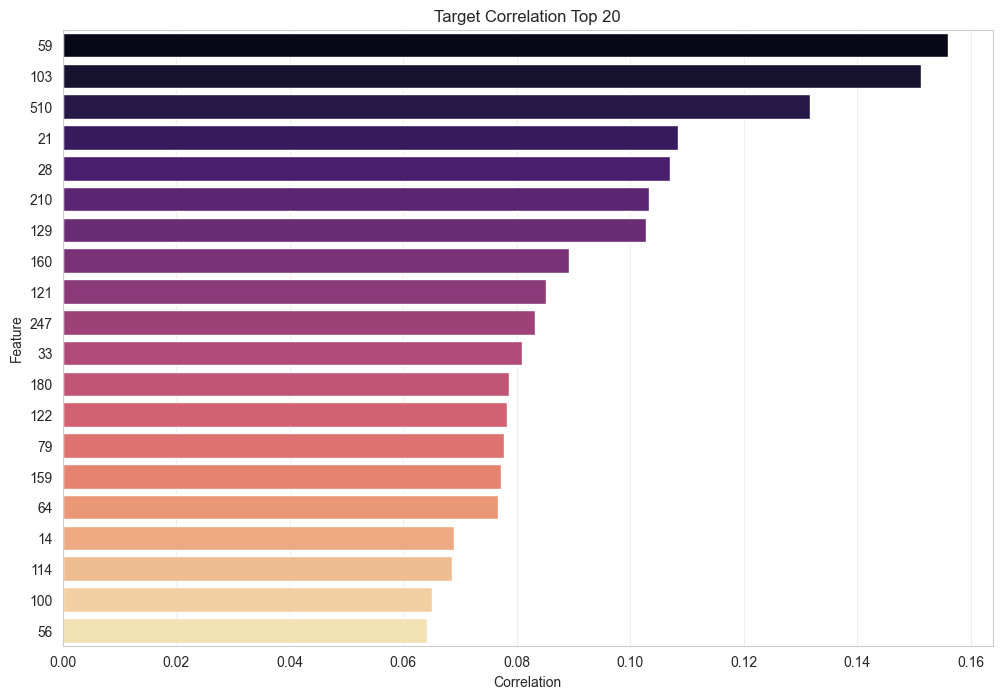

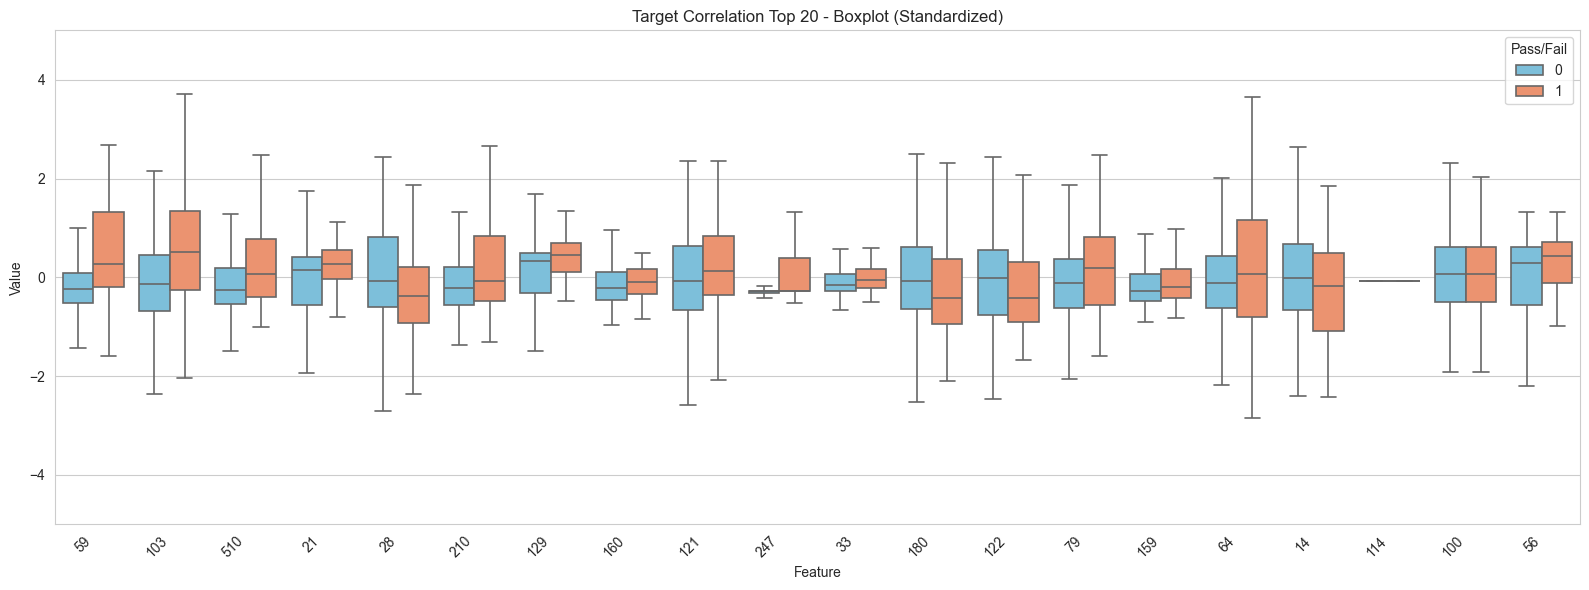

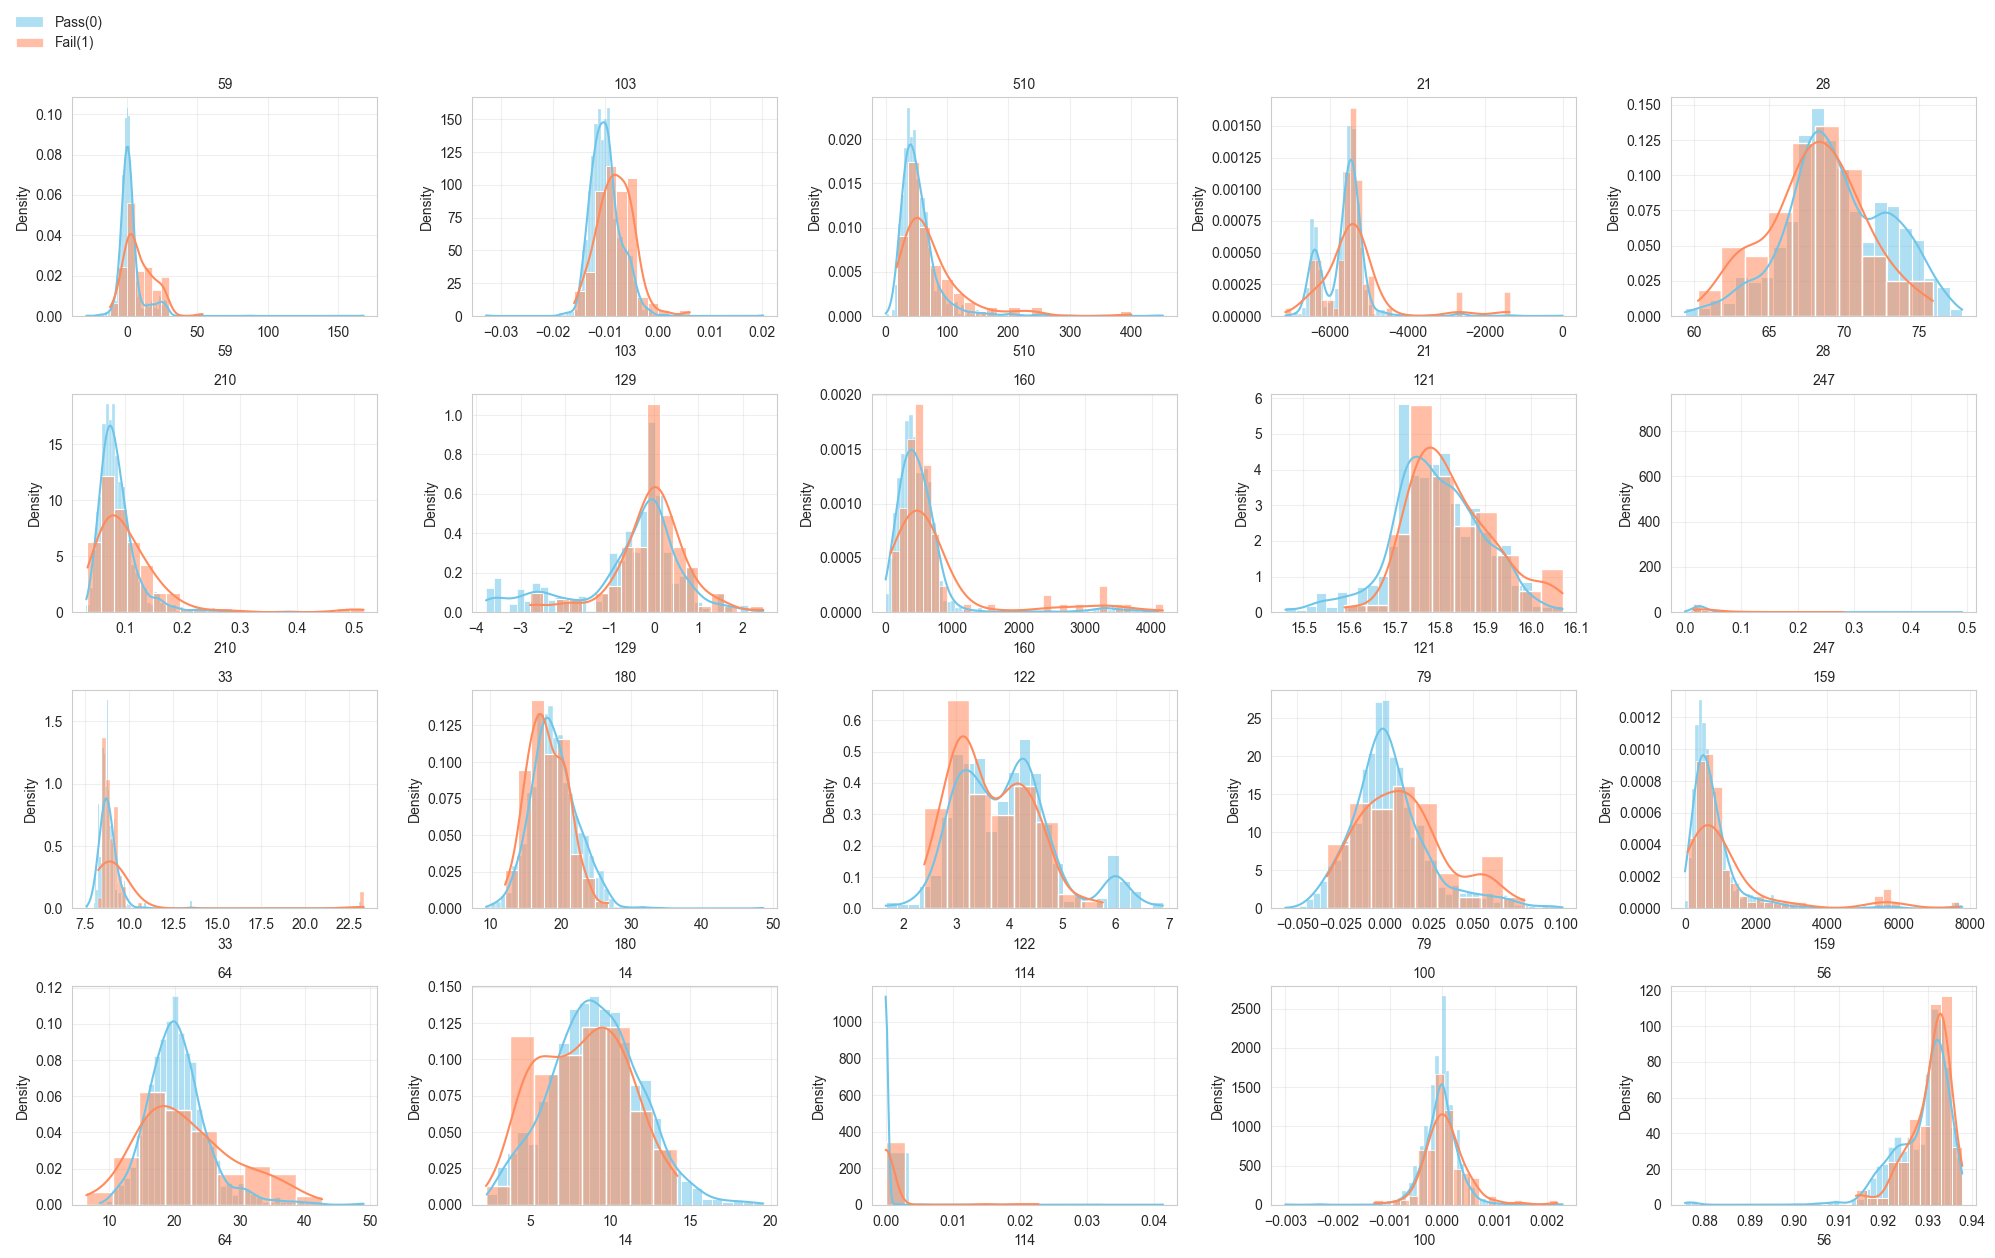

In [44]:
# Target Correlation Top 20
corr_with_target = X_imputed.corrwith(y).abs().sort_values(ascending=False)
top20_corr = corr_with_target.head(20)
top20 = top20_corr.index.tolist()

print(f"  Corr Top 20: {', '.join(top20_corr.index)}")

sns.set_style("whitegrid")
target = "Pass/Fail"
palette_pf = {0: "#6EC5E9", 1: "#FF8A5B", "0": "#6EC5E9", "1": "#FF8A5B"}

# =========================
# 1) 막대 그래프
# =========================
plt.figure(figsize=(12, 8))
sns.barplot(x=top20_corr.values, y=top20_corr.index.astype(str), palette='magma')
plt.title('Target Correlation Top 20')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.show()

# =========================
# 2) 박스플롯 (Top 20, 표준화)
# =========================
df_std = df.copy()
df_std[top20] = (df_std[top20] - df_std[top20].mean()) / df_std[top20].std()

df_melt = df_std.melt(id_vars=target, value_vars=top20, var_name="Feature", value_name="Value")

plt.figure(figsize=(16, 6))
sns.boxplot(
    data=df_melt,
    x="Feature",
    y="Value",
    hue=target,
    palette=palette_pf,
    linewidth=1.2,
    fliersize=0,
    whis=1.5
)
plt.ylim(-5, 5)
plt.xticks(rotation=45, ha='right')
plt.title("Target Correlation Top 20 - Boxplot (Standardized)")
plt.tight_layout()
plt.show()

# =========================
# 3) 히스토그램 (Top 20, 4x5)
# =========================
g0 = df[df[target].astype(str) == "0"]
g1 = df[df[target].astype(str) == "1"]

fig, axes = plt.subplots(4, 5, figsize=(20, 12))
for ax, col in zip(axes.flatten(), top20):
    sns.histplot(g0[col], color="#6EC5E9", label="Pass(0)", kde=True,
                 ax=ax, stat="density", alpha=0.55)
    sns.histplot(g1[col], color="#FF8A5B", label="Fail(1)", kde=True,
                 ax=ax, stat="density", alpha=0.55)
    ax.set_title(str(col), fontsize=10)
    ax.grid(alpha=0.3)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left",
           bbox_to_anchor=(0.001, 1.05), frameon=False)
plt.tight_layout()
plt.show()

## 5. Train / Valid / Test 분리 + ANOVA 피처 선택
> 70 / 15 / 15 (stratified, seed=42) → ANOVA Top 20 피처 선택 (Train only)

In [45]:
target = "Pass/Fail"
X = df.drop(columns=[target])
y = df[target].astype(int)

# 1) 먼저 분리
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 2) Train으로만 피처 선택
k = 20
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("anova", SelectKBest(score_func=f_classif, k=k))
])
pipe.fit(X_train, y_train)

selected_cols = X_train.columns[pipe.named_steps["anova"].get_support()]

# 3) Train/Valid/Test 모두 동일 컬럼만 유지
X_train = X_train[selected_cols]
X_valid = X_valid[selected_cols]
X_test  = X_test[selected_cols]

print(f"  ANOVA Top {k}: {', '.join(selected_cols)}")
print(f"  Train {X_train.shape[0]:,} | Valid {X_valid.shape[0]:,} | Test {X_test.shape[0]:,}  (×{X_train.shape[1]} features)")


  ANOVA Top 20: 14, 21, 28, 59, 63, 64, 68, 78, 95, 100, 103, 121, 122, 129, 180, 210, 213, 247, 510, 511
  Train 1,096 | Valid 235 | Test 236  (×20 features)


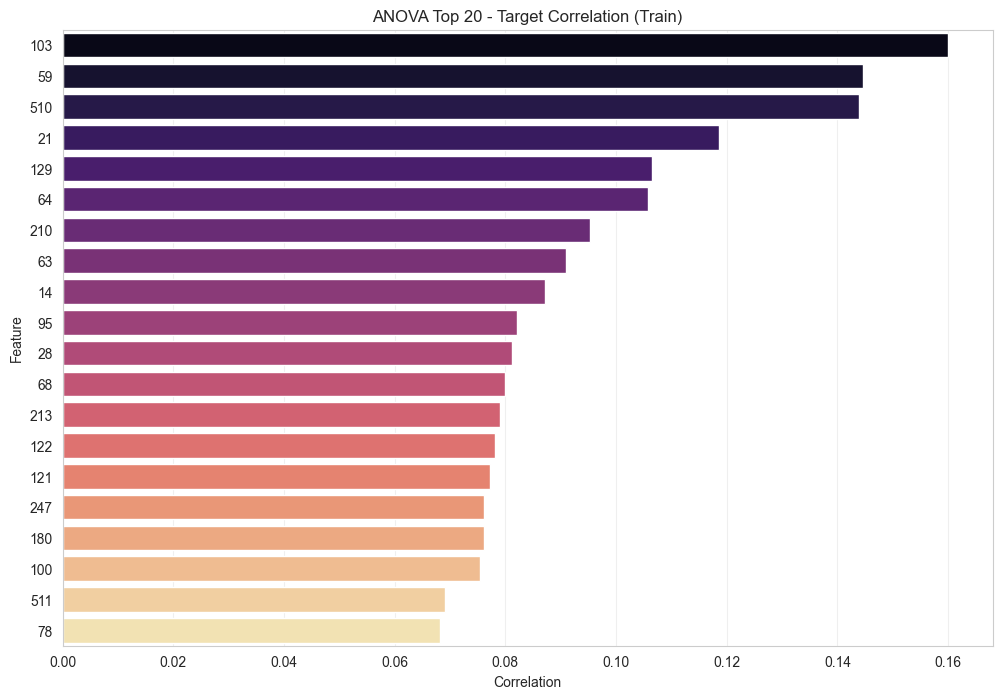

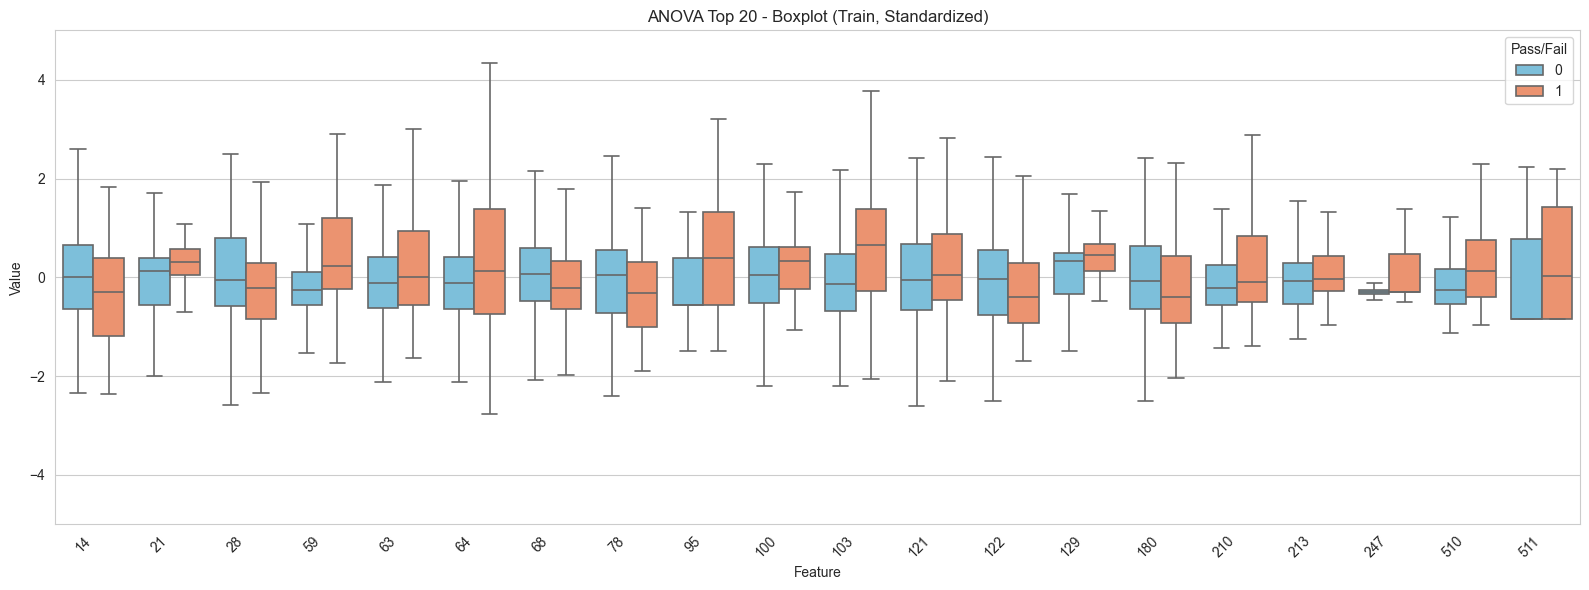

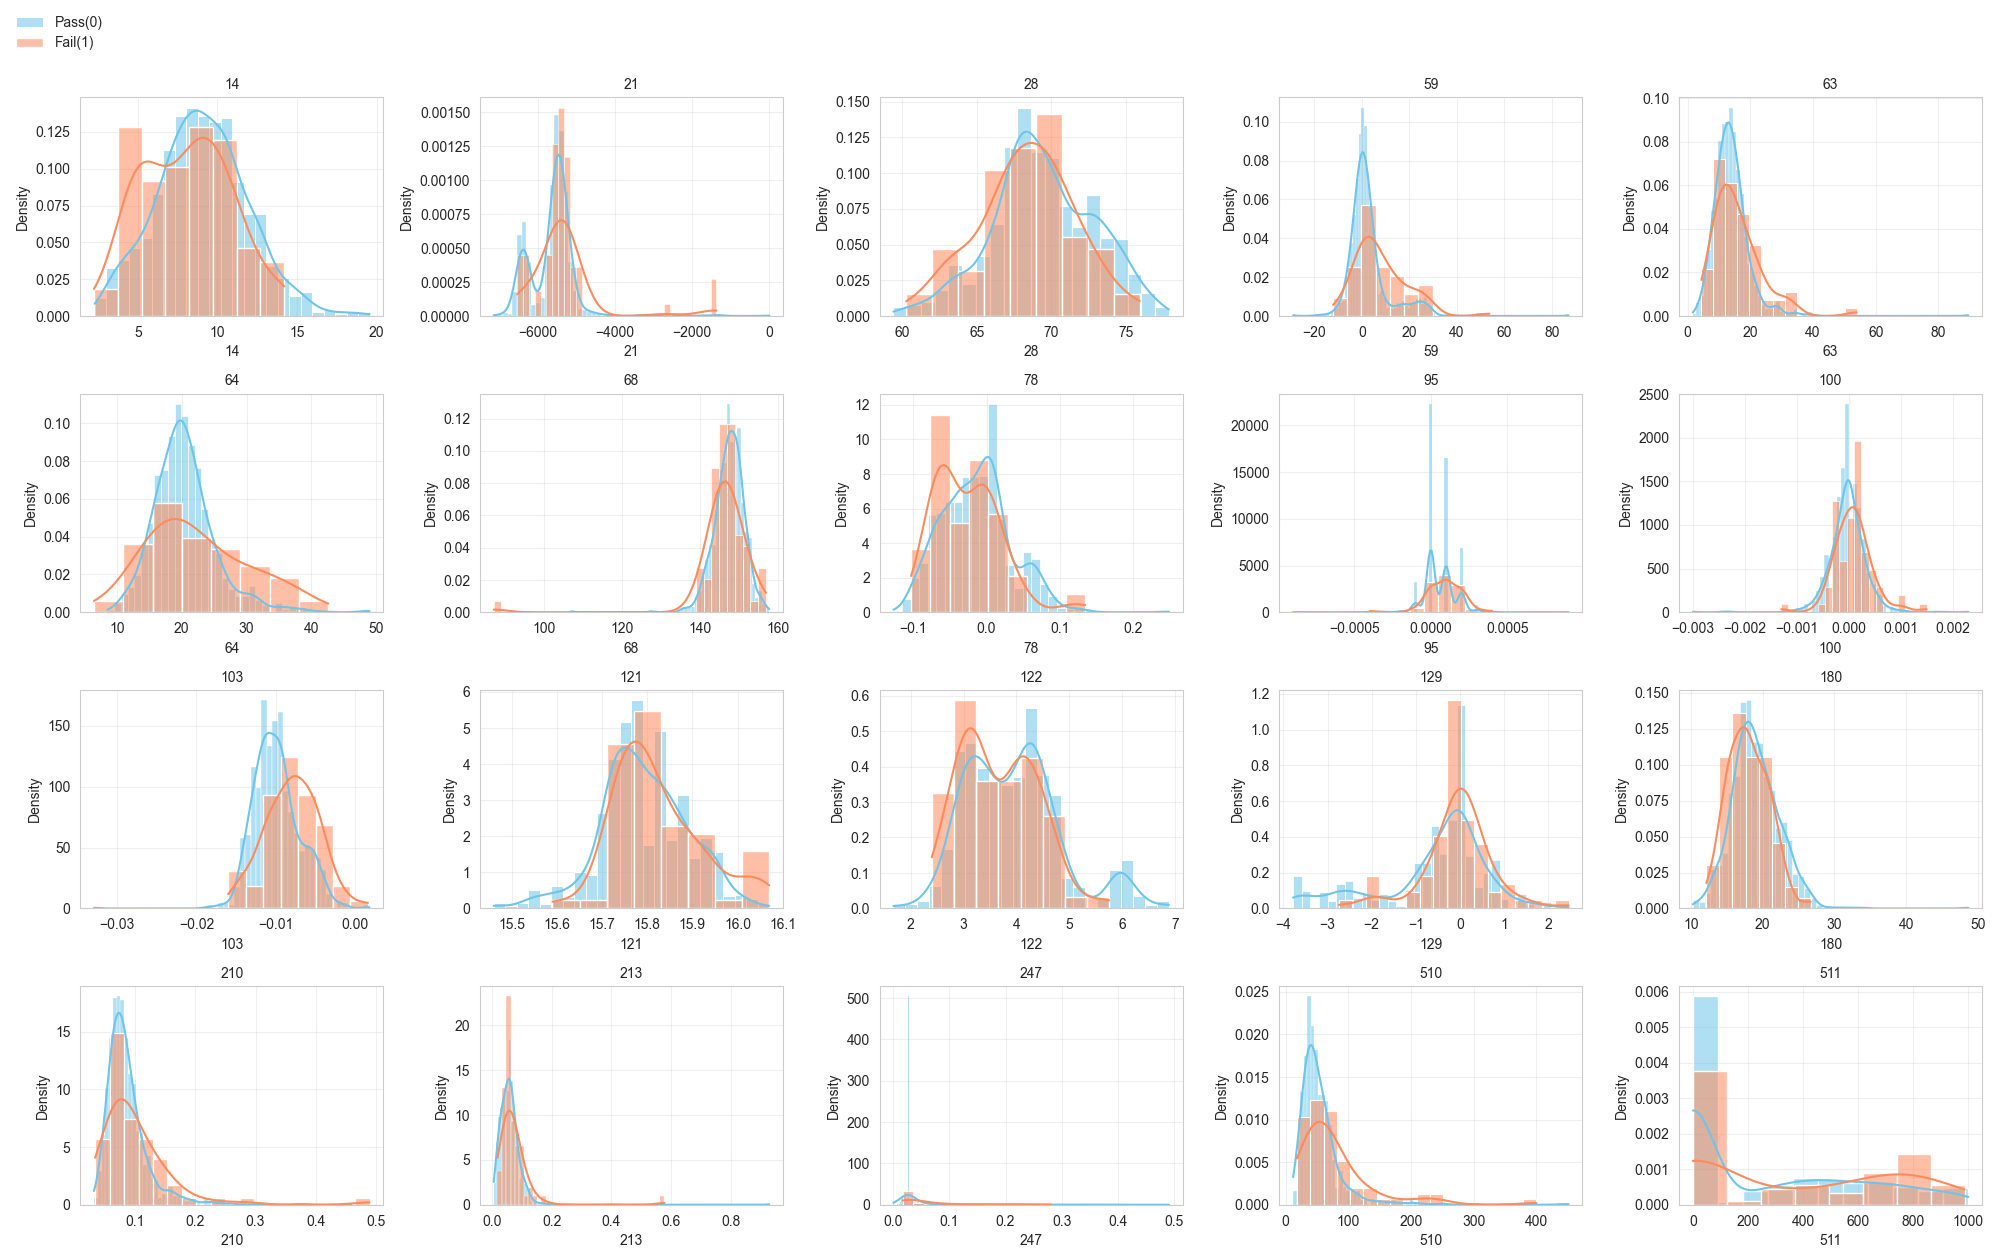

In [46]:
# =========================================
# 5. ANOVA Top 20 시각화 (Train only)
# =========================================
sns.set_style("whitegrid")

top20_anova = selected_cols.tolist()

# 1) Correlation bar chart (train data)
corr_train = X_train.corrwith(y_train).abs().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=corr_train.values, y=corr_train.index.astype(str), palette='magma')
plt.title('ANOVA Top 20 - Target Correlation (Train)')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.show()

# 2) Boxplot (train, standardized)
df_train = X_train.copy()
df_train['Pass/Fail'] = y_train.values

df_std = df_train.copy()
df_std[top20_anova] = (df_std[top20_anova] - df_std[top20_anova].mean()) / df_std[top20_anova].std()

df_melt = df_std.melt(id_vars='Pass/Fail', value_vars=top20_anova, var_name='Feature', value_name='Value')

plt.figure(figsize=(16, 6))
sns.boxplot(
    data=df_melt, x='Feature', y='Value', hue='Pass/Fail',
    palette={0: '#6EC5E9', 1: '#FF8A5B'},
    linewidth=1.2, fliersize=0, whis=1.5
)
plt.ylim(-5, 5)
plt.xticks(rotation=45, ha='right')
plt.title('ANOVA Top 20 - Boxplot (Train, Standardized)')
plt.tight_layout()
plt.show()

# 3) Histogram (4x5, train)
g0 = df_train[df_train['Pass/Fail'] == 0]
g1 = df_train[df_train['Pass/Fail'] == 1]

fig, axes = plt.subplots(4, 5, figsize=(20, 12))
for ax, col in zip(axes.flatten(), top20_anova):
    sns.histplot(g0[col], color='#6EC5E9', label='Pass(0)', kde=True,
                 ax=ax, stat='density', alpha=0.55)
    sns.histplot(g1[col], color='#FF8A5B', label='Fail(1)', kde=True,
                 ax=ax, stat='density', alpha=0.55)
    ax.set_title(str(col), fontsize=10)
    ax.grid(alpha=0.3)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',
           bbox_to_anchor=(0.001, 1.05), frameon=False)
plt.tight_layout()
plt.show()

## 6. 3종 샘플링 × 5 모델 비교
Baseline / Undersampling / SMOTE × 5개 모델 = **15개 조합**
- 퇴화 모델 제거: 반대쪽 지표 ≥ 0.3 하한 필터
- Top 3 선택 → Phase 3 앙상블 입력

In [47]:
# --- 모델 정의 ---
models_def = {
    "Logistic": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestClassifier(
            n_estimators=300, max_depth=12, random_state=42,
            n_jobs=-1, class_weight="balanced"
        ))
    ]),
    "HistGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingClassifier(
            max_depth=8, learning_rate=0.05, random_state=42
        ))
    ]),
    "XGBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBClassifier(
            n_estimators=300, max_depth=8, learning_rate=0.05,
            random_state=42, n_jobs=-1, eval_metric="logloss"
        ))
    ]),
    "LightGBM": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMClassifier(
            n_estimators=300, max_depth=8, learning_rate=0.05,
            random_state=42, n_jobs=-1, verbose=-1
        ))
    ]),
}

# --- 평가 함수 ---
def eval_model(name, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_va)[:, 1]
    pred = (proba >= 0.5).astype(int)
    cm = confusion_matrix(y_va, pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        "model": name,
        "ROC-AUC": roc_auc_score(y_va, proba),
        "PR-AUC": average_precision_score(y_va, proba),
        "Precision": precision_score(y_va, pred, zero_division=0),
        "Recall": recall_score(y_va, pred, zero_division=0),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "F1": f1_score(y_va, pred, zero_division=0),
    }, cm


### 6-1. 개별 모델 베이스라인 (Baseline, threshold=0.5)

model  Recall  Specificity  BalAcc
0      Logistic  0.6667       0.7455  0.7061
1  RandomForest  0.0000       1.0000  0.5000
2        HistGB  0.0000       0.9955  0.4977
3       XGBoost  0.0000       0.9955  0.4977
4      LightGBM  0.0000       0.9909  0.4955

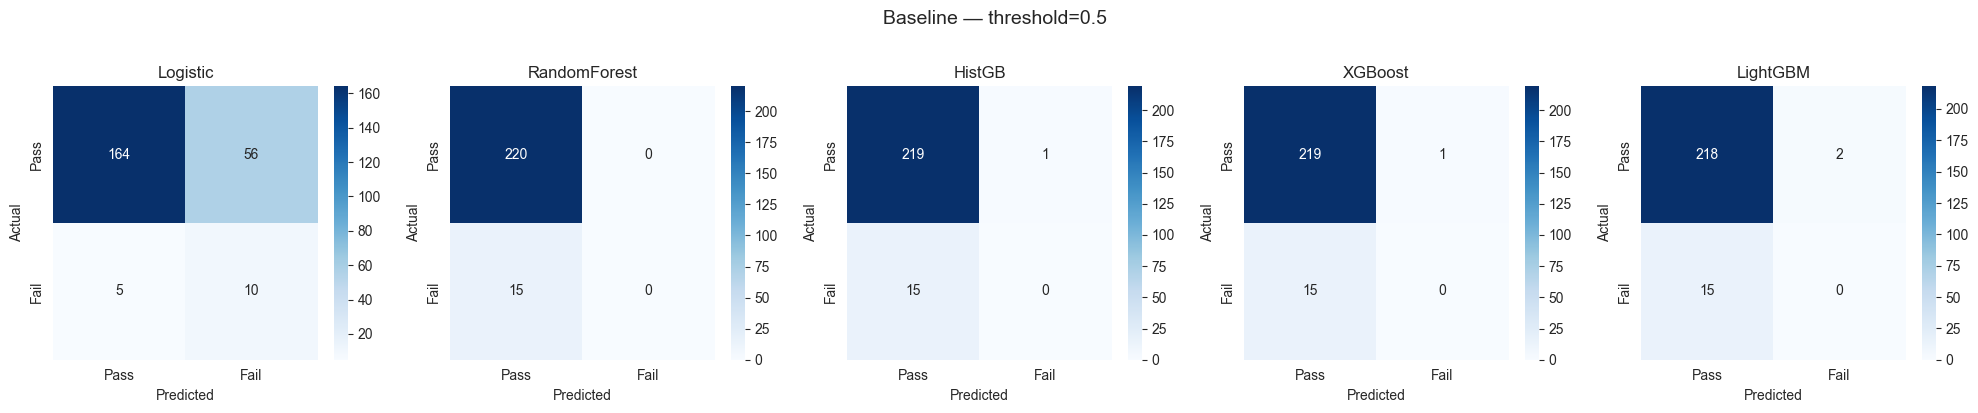

In [48]:
# Baseline (샘플링 없음) 5개 모델 베이스라인
baseline_results = []
baseline_cms = {}

for name, model_template in models_def.items():
    model = clone(model_template)
    result, cm = eval_model(name, model, X_train, y_train, X_valid, y_valid)
    result['Specificity'] = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    result['BalAcc'] = (result['Recall'] + result['Specificity']) / 2
    baseline_results.append(result)
    baseline_cms[name] = cm

display(pd.DataFrame(baseline_results)[['model', 'Recall', 'Specificity', 'BalAcc']].sort_values('BalAcc', ascending=False))

# Confusion Matrix (threshold=0.5)
n = len(baseline_cms)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
for ax, (name, cm) in zip(axes, baseline_cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.suptitle("Baseline — threshold=0.5", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### 6-2. 3종 샘플링 × 5 모델 = 15개 조합 비교

model  Recall  Specificity  BalAcc
0      Under_RandomForest  0.8000       0.6773  0.7386
1            Under_HistGB  0.6667       0.6636  0.6652
2          Under_Logistic  0.7333       0.6818  0.7076
3   Baseline_RandomForest  0.0000       1.0000  0.5000
4          SMOTE_Logistic  0.6667       0.7636  0.7152
5       Baseline_Logistic  0.6667       0.7455  0.7061
6         Baseline_HistGB  0.0000       0.9955  0.4977
7      SMOTE_RandomForest  0.1333       0.9773  0.5553
8           Under_XGBoost  0.8000       0.6000  0.7000
9        Baseline_XGBoost  0.0000       0.9955  0.4977
10      Baseline_LightGBM  0.0000       0.9909  0.4955
11           SMOTE_HistGB  0.0667       0.9682  0.5174
12         SMOTE_LightGBM  0.0667       0.9773  0.5220
13          SMOTE_XGBoost  0.0667       0.9773  0.5220
14         Under_LightGBM  0.6667       0.6136  0.6402

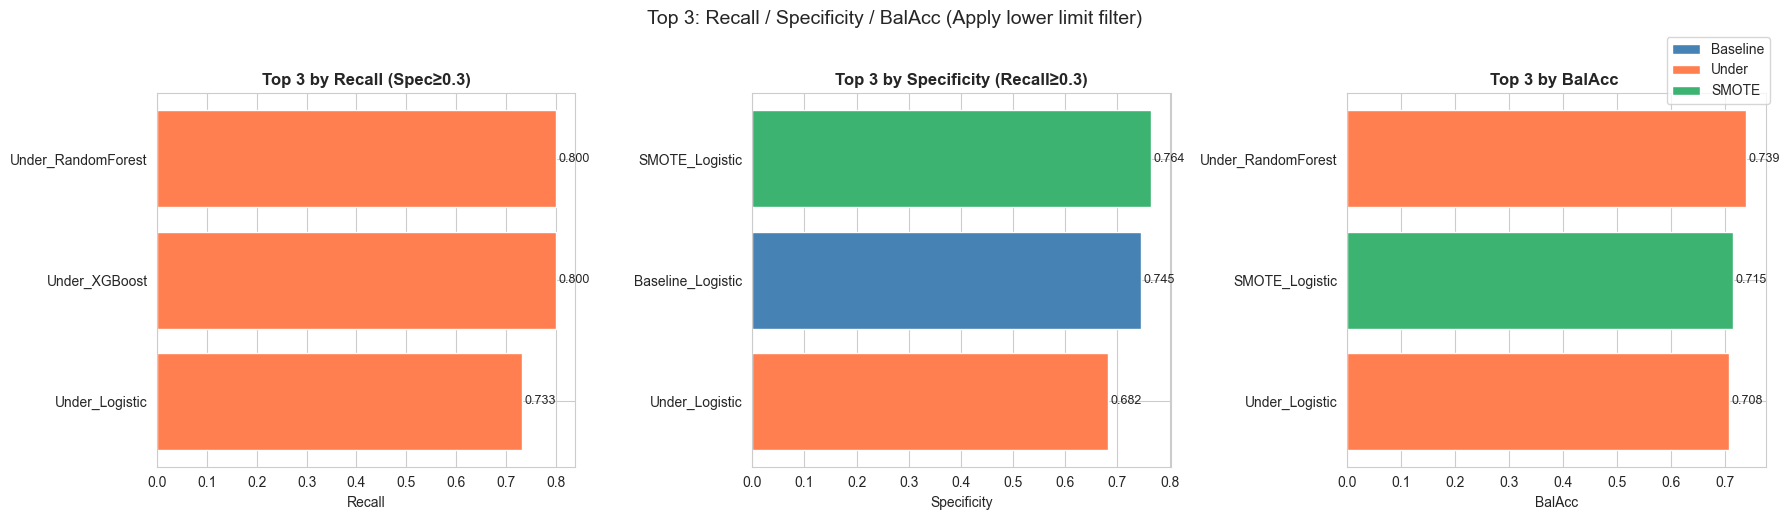

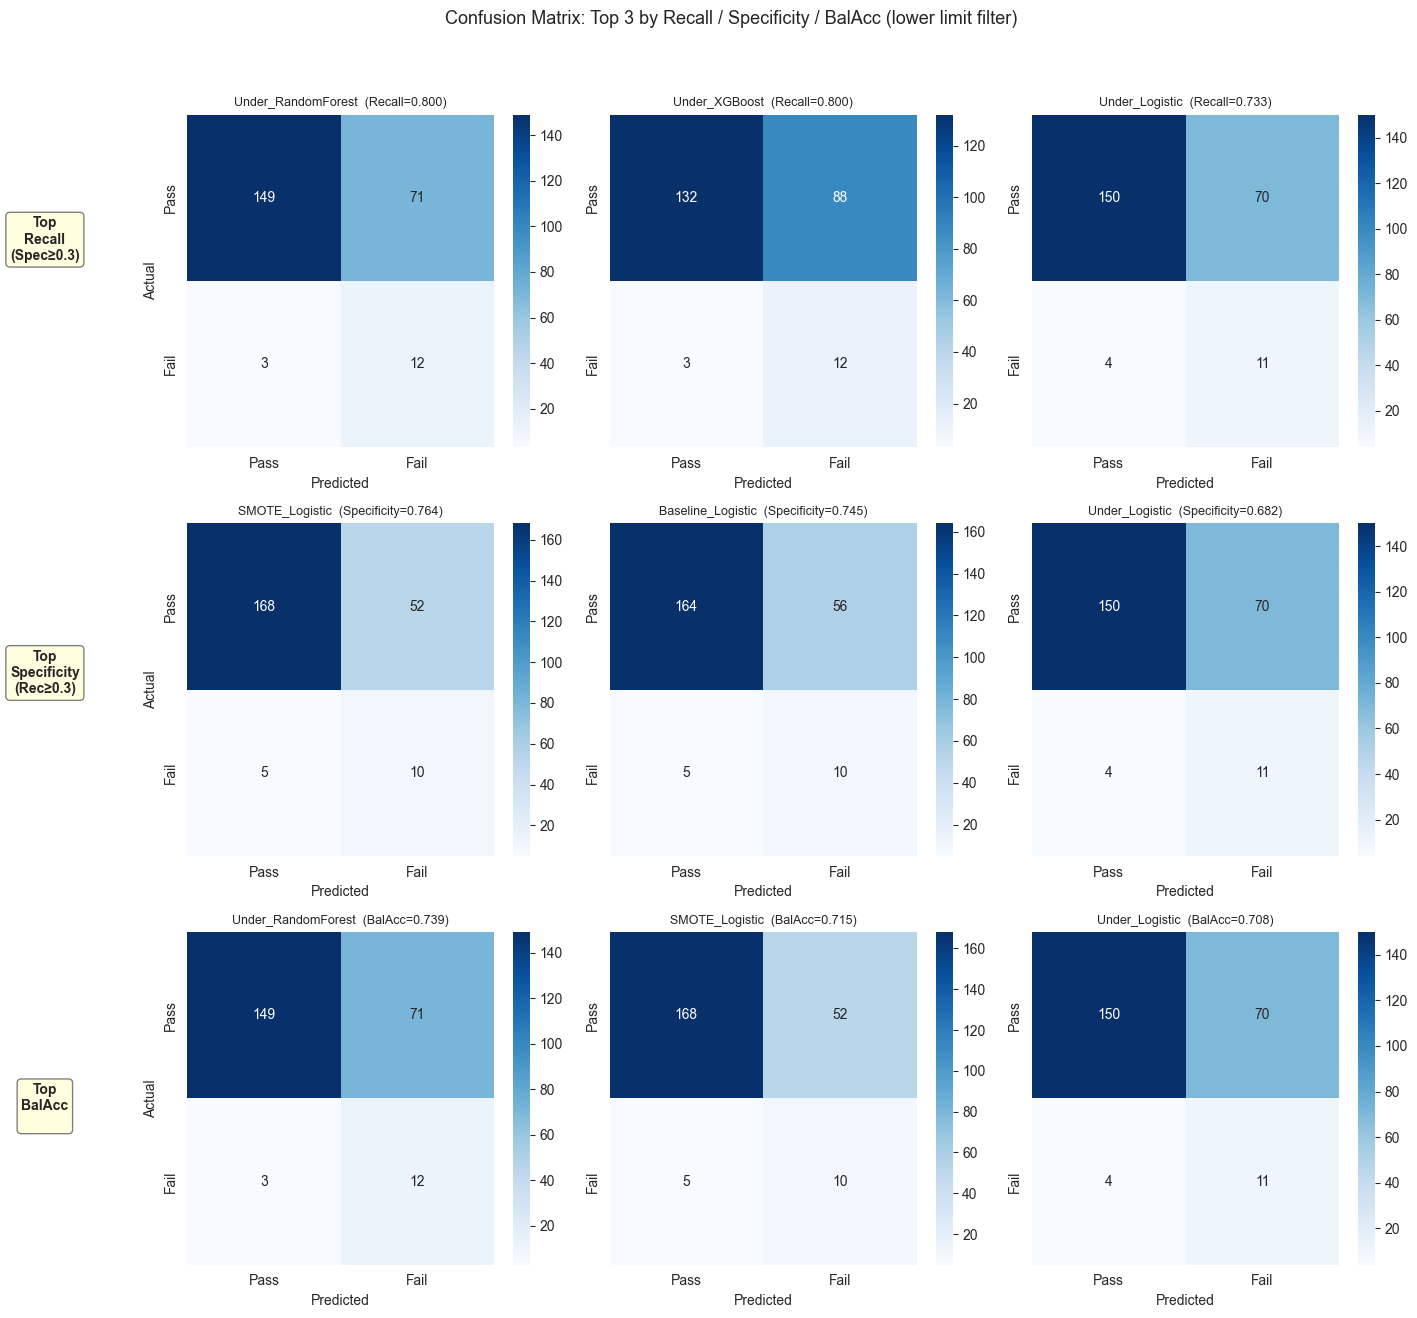

In [49]:
# === 3종 샘플링 × 5 모델 = 15개 조합 ===
sampling_methods = OrderedDict([
    ("Baseline", None),
    ("Under",  RandomUnderSampler(random_state=42)),
    ("SMOTE",  SMOTE(random_state=42)),
])

all_results = []
trained_models = {}

for samp_name, sampler in sampling_methods.items():
    if sampler is not None:
        imp = SimpleImputer(strategy="median")
        X_tr_s = pd.DataFrame(
            imp.fit_transform(X_train),
            columns=X_train.columns
        )
        X_tr_s, y_tr_s = sampler.fit_resample(X_tr_s, y_train)
    else:
        X_tr_s, y_tr_s = X_train.copy(), y_train.copy()

    for model_name, model_template in models_def.items():
        model = clone(model_template)
        combo = f"{samp_name}_{model_name}"
        result, cm = eval_model(combo, model, X_tr_s, y_tr_s, X_valid, y_valid)
        all_results.append(result)
        trained_models[combo] = model

df_results = pd.DataFrame(all_results)
df_results["BalAcc"] = (df_results["Recall"] + df_results["Specificity"]) / 2
df_results = df_results.sort_values("PR-AUC", ascending=False).reset_index(drop=True)
display(df_results[['model', 'Recall', 'Specificity', 'BalAcc']])

# --- 하한 필터 함수 (퇴화 모델 제거) ---
MIN_OPP = 0.3

def get_top3_filtered(df, metric):
    """Recall top → Spec≥0.3 풀, Spec top → Recall≥0.3 풀, BalAcc → 전체"""
    if metric == "Recall":
        pool = df[df["Specificity"] >= MIN_OPP]
    elif metric == "Specificity":
        pool = df[df["Recall"] >= MIN_OPP]
    else:
        pool = df
    return pool.sort_values(metric, ascending=False).head(3).reset_index(drop=True)

# --- Top 3 바차트 (Recall / Specificity / BalAcc) ---
metrics_top = ["Recall", "Specificity", "BalAcc"]
palette = {"Baseline": "steelblue", "Under": "coral", "SMOTE": "mediumseagreen"}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, metrics_top):
    top3_m = get_top3_filtered(df_results, metric)
    colors = [palette[r.split("_")[0]] for r in top3_m["model"]]
    bars = ax.barh(range(3), top3_m[metric], color=colors)
    ax.set_yticks(range(3))
    ax.set_yticklabels(top3_m["model"], fontsize=10)
    ax.set_xlabel(metric)
    filt = "(Spec≥0.3)" if metric == "Recall" else "(Recall≥0.3)" if metric == "Specificity" else ""
    ax.set_title(f"Top 3 by {metric} {filt}", fontsize=12, fontweight="bold")
    ax.invert_yaxis()
    for i, v in enumerate(top3_m[metric]):
        ax.text(v + 0.005, i, f"{v:.3f}", va="center", fontsize=9)

legend_elements = [Patch(facecolor=c, label=n) for n, c in palette.items()]
fig.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(0.99, 0.99))
plt.suptitle("Top 3: Recall / Specificity / BalAcc (Apply lower limit filter)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

# --- Confusion Matrix 3x3 (각 지표 Top 3, 필터 적용) ---
fig, axes = plt.subplots(3, 3, figsize=(14, 13))
row_metrics = ["Recall", "Specificity", "BalAcc"]

for row_idx, metric in enumerate(row_metrics):
    top3_m = get_top3_filtered(df_results, metric)
    for col_idx in range(3):
        r = top3_m.iloc[col_idx]
        combo = r["model"]
        m = trained_models[combo]
        proba = m.predict_proba(X_valid)[:, 1]
        pred = (proba >= 0.5).astype(int)
        cm = confusion_matrix(y_valid, pred)
        ax = axes[row_idx][col_idx]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pass", "Fail"], yticklabels=["Pass", "Fail"], ax=ax)
        val = r[metric]
        ax.set_title(f"{combo}  ({metric}={val:.3f})", fontsize=9)
        ax.set_xlabel("Predicted")
        if col_idx == 0:
            ax.set_ylabel("Actual", fontsize=10)
        else:
            ax.set_ylabel("")

# 행 라벨 추가
for row_idx, label in enumerate(row_metrics):
    mid_y = 1 - (row_idx + 0.5) / 3
    filt = "(Spec≥0.3)" if label == "Recall" else "(Rec≥0.3)" if label == "Specificity" else ""
    fig.text(0.01, mid_y, f"Top\n{label}\n{filt}", fontsize=10, fontweight="bold",
             va="center", ha="center", rotation=0,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", edgecolor="gray"))

plt.suptitle("Confusion Matrix: Top 3 by Recall / Specificity / BalAcc (lower limit filter)", y=1.01, fontsize=13)
plt.tight_layout(rect=[0.07, 0, 1, 0.98])
plt.show()


## 7. Soft Voting 앙상블

**Top 3 모델 선택 (역할 분담 + 하한 필터)**
1. Recall 1위 (Spec ≥ 0.3 풀)
2. Specificity 1위 (Recall ≥ 0.3 풀)
3. BalAcc 순 (1·2 중복 제거 후 최상위)

선택된 3개 모델로 **26가지 가중치 × 91 threshold** 동시 탐색 → Valid BalAcc 최적화

  앙상블 모델 선택 (역할 분담, 하한 필터 ≥ 0.3)
  Recall 1위 (Spec≥0.3) : Under_RandomForest
    Recall=0.800  Spec=0.677  BalAcc=0.739
  Spec 1위  (Rec≥0.3) : SMOTE_Logistic
    Recall=0.667  Spec=0.764  BalAcc=0.715
  BalAcc (밸런스)     : Under_Logistic
    Recall=0.733  Spec=0.682  BalAcc=0.708


weights  threshold  Recall  Specificity  BalAcc
16     [4,1,1]     0.4600  1.0000       0.6273  0.8136
4      [3,1,1]     0.4500  1.0000       0.6045  0.8023
10     [3,2,1]     0.4300  1.0000       0.6045  0.8023
1      [2,1,1]     0.4400  1.0000       0.6000  0.8000
19     [3,3,1]     0.4200  1.0000       0.5955  0.7977
11     [3,1,2]     0.4400  1.0000       0.5955  0.7977
22     [5,1,1]     0.4500  1.0000       0.5955  0.7977
20     [3,1,3]     0.4400  1.0000       0.5955  0.7977
8      [2,1,2]     0.4300  1.0000       0.5909  0.7955
14     [2,1,3]     0.4300  1.0000       0.5909  0.7955
7      [2,2,1]     0.4200  1.0000       0.5864  0.7932
0   균등 [1,1,1]     0.4200  1.0000       0.5818  0.7909
25     [2,2,2]     0.4200  1.0000       0.5818  0.7909
18     [1,1,4]     0.4200  1.0000       0.5818  0.7909
3      [1,1,2]     0.4200  1.0000       0.5773  0.7886
12     [2,3,1]     0.4000  1.0000       0.5773  0.7886
6      [1,1,3]     0.4200  1.0000       0.5682  0.7841
9      [1,2,2]     0.4000  1.0000       0.5636  0.7818
21     [1,3,3]     0.4600  0.8667       0.6909  0.7788
2      [1,2,1]     0.3900  1.0000       0.5545  0.7773
13     [1,3,2]     0.4500  0.8667       0.6864  0.7765
24     [1,1,5]     0.4100  1.0000       0.5500  0.7750
5      [1,3,1]     0.3700  1.0000       0.5455  0.7727
15     [1,2,3]     0.4000  1.0000       0.5409  0.7705
17     [1,4,1]     0.3600  1.0000       0.5364  0.7682
23     [1,5,1]     0.3500  1.0000       0.5273  0.7636


  Best Weights : [4,1,1]
  Threshold    : 0.46
  BalAcc       : 0.8136


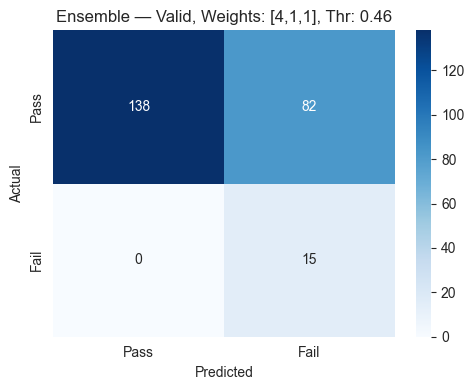

In [50]:
# === 앙상블 모델 조합: 역할 분담 + 하한 필터 ===
# Recall 1위: Spec >= 0.3 인 모델 중
# Spec 1위: Recall >= 0.3 인 모델 중
# BalAcc 1위: 필터 없음
MIN_OPP = 0.3

pick_recall = df_results[df_results['Specificity'] >= MIN_OPP].sort_values('Recall', ascending=False).iloc[0]['model']

pool_spec = df_results[df_results['Recall'] >= MIN_OPP]
if len(pool_spec) > 0:
    pick_spec = pool_spec.sort_values('Specificity', ascending=False).iloc[0]['model']
else:
    pick_spec = df_results.sort_values('BalAcc', ascending=False).iloc[0]['model']

pick_bal = df_results.sort_values('BalAcc', ascending=False).iloc[0]['model']

# 중복 제거
picks = list(dict.fromkeys([pick_recall, pick_spec, pick_bal]))
if len(picks) < 3:
    for _, row in df_results.sort_values('BalAcc', ascending=False).iterrows():
        if row['model'] not in picks:
            picks.append(row['model'])
        if len(picks) == 3:
            break

top3 = picks
print('=' * 60)
print('  앙상블 모델 선택 (역할 분담, 하한 필터 ≥ 0.3)')
print('=' * 60)
for i, n in enumerate(top3):
    row = df_results[df_results['model'] == n].iloc[0]
    if n == pick_recall:
        label = 'Recall 1위 (Spec≥0.3)'
    elif n == pick_spec:
        label = 'Spec 1위  (Rec≥0.3)'
    else:
        label = 'BalAcc (밸런스)    '
    print(f'  {label} : {n}')
    print(f'    Recall={row["Recall"]:.3f}  Spec={row["Specificity"]:.3f}  BalAcc={row["BalAcc"]:.3f}')
print('=' * 60)

def soft_vote(model_names, models_dict, X, weights=None):
    probas = [models_dict[n].predict_proba(X)[:, 1] for n in model_names]
    return np.average(probas, axis=0, weights=weights)

# --- 가중치 × threshold 동시 탐색 ---
weight_configs = OrderedDict([
    # --- 균등 ---
    ('균등 [1,1,1]', None),
    # --- 2:1 계열 ---
    ('[2,1,1]', [2, 1, 1]),
    ('[1,2,1]', [1, 2, 1]),
    ('[1,1,2]', [1, 1, 2]),
    # --- 3:1 계열 ---
    ('[3,1,1]', [3, 1, 1]),
    ('[1,3,1]', [1, 3, 1]),
    ('[1,1,3]', [1, 1, 3]),
    # --- 2:2:1 계열 ---
    ('[2,2,1]', [2, 2, 1]),
    ('[2,1,2]', [2, 1, 2]),
    ('[1,2,2]', [1, 2, 2]),
    # --- 3:2:1 계열 (6가지) ---
    ('[3,2,1]', [3, 2, 1]),
    ('[3,1,2]', [3, 1, 2]),
    ('[2,3,1]', [2, 3, 1]),
    ('[1,3,2]', [1, 3, 2]),
    ('[2,1,3]', [2, 1, 3]),
    ('[1,2,3]', [1, 2, 3]),
    # --- 4:1 계열 ---
    ('[4,1,1]', [4, 1, 1]),
    ('[1,4,1]', [1, 4, 1]),
    ('[1,1,4]', [1, 1, 4]),
    # --- 3:3:1 계열 ---
    ('[3,3,1]', [3, 3, 1]),
    ('[3,1,3]', [3, 1, 3]),
    ('[1,3,3]', [1, 3, 3]),
    # --- 5:1 계열 ---
    ('[5,1,1]', [5, 1, 1]),
    ('[1,5,1]', [1, 5, 1]),
    ('[1,1,5]', [1, 1, 5]),
    # --- 균등 고배 ---
    ('[2,2,2]', [2, 2, 2]),
])

thresholds = np.linspace(0.05, 0.95, 91)

ens_results = []
for w_name, w in weight_configs.items():
    proba_va = soft_vote(top3, trained_models, X_valid, w)

    best_bal, best_thr = 0, 0.5
    for thr in thresholds:
        pred = (proba_va >= thr).astype(int)
        cm = confusion_matrix(y_valid, pred)
        tn, fp, fn, tp = cm.ravel()
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        bal = (rec + spec) / 2
        if bal > best_bal:
            best_bal = bal
            best_thr = thr

    pred = (proba_va >= best_thr).astype(int)
    cm = confusion_matrix(y_valid, pred)
    tn, fp, fn, tp = cm.ravel()
    rec = recall_score(y_valid, pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ens_results.append({
        'weights': w_name,
        'threshold': best_thr,
        'PR-AUC': average_precision_score(y_valid, proba_va),
        'Recall': rec,
        'Specificity': spec,
        'BalAcc': (rec + spec) / 2,
        'Precision': precision_score(y_valid, pred, zero_division=0),
        'F1': f1_score(y_valid, pred, zero_division=0),
    })

df_ens = pd.DataFrame(ens_results)
display(df_ens[['weights', 'threshold', 'Recall', 'Specificity', 'BalAcc']].sort_values('BalAcc', ascending=False))

# --- Best 선택 ---
best_idx = df_ens['BalAcc'].idxmax()
best_w_name = df_ens.loc[best_idx, 'weights']
best_w = weight_configs[best_w_name]
best_thr = df_ens.loc[best_idx, 'threshold']
print()
print(f'  Best Weights : {best_w_name}')
print(f'  Threshold    : {best_thr:.2f}')
print(f'  BalAcc       : {df_ens.loc[best_idx, "BalAcc"]:.4f}')

# Confusion Matrix
proba_va = soft_vote(top3, trained_models, X_valid, best_w)
pred_va = (proba_va >= best_thr).astype(int)
cm_va = confusion_matrix(y_valid, pred_va)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_va, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=ax)
ax.set_title(f'Ensemble — Valid, Weights: {best_w_name}, Thr: {best_thr:.2f}')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()


  Test Set 최종 평가 (Soft Voting Ensemble)
  Models : ['Under_RandomForest', 'SMOTE_Logistic', 'Under_Logistic']
  Config : weights=[4,1,1], threshold=0.46
  ───────────────────────────────────────────────
  PR-AUC=0.2163  Recall=0.8125  Spec=0.6227
  Prec  =0.1354  F1    =0.2321  BalAcc=0.7176


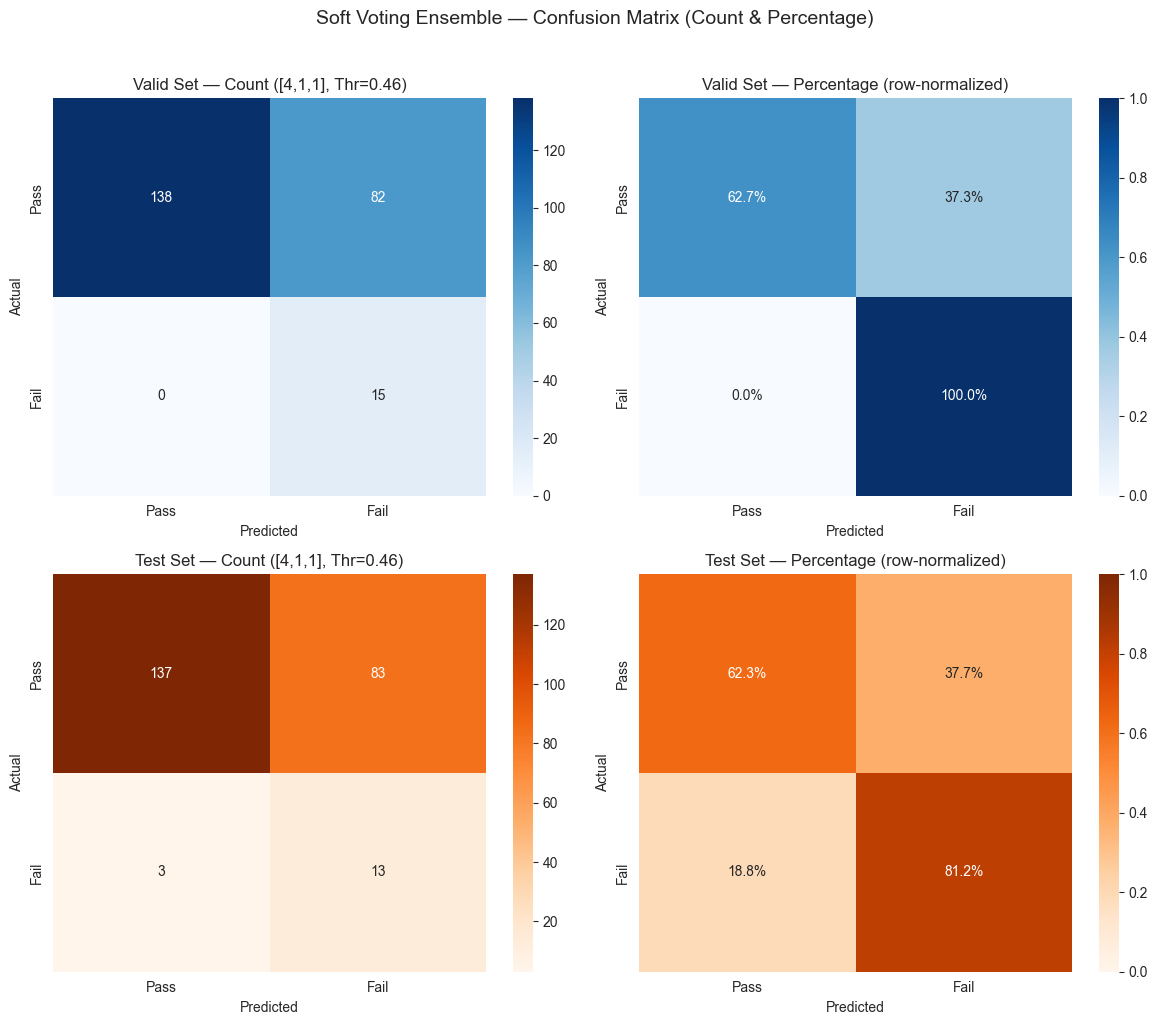

In [51]:
# === 최종 Test Set 평가 ===
proba_te = soft_vote(top3, trained_models, X_test, best_w)
pred_te = (proba_te >= best_thr).astype(int)

cm_test = confusion_matrix(y_test, pred_te)
tn, fp, fn, tp = cm_test.ravel()
rec_te = recall_score(y_test, pred_te, zero_division=0)
spec_te = tn / (tn + fp) if (tn + fp) > 0 else 0

print("=" * 55)
print("  Test Set 최종 평가 (Soft Voting Ensemble)")
print("=" * 55)
print(f"  Models : {top3}")
print(f"  Config : weights={best_w_name}, threshold={best_thr:.2f}")
print(f"  ───────────────────────────────────────────────")
pr_auc = average_precision_score(y_test, proba_te)
prec = precision_score(y_test, pred_te, zero_division=0)
f1 = f1_score(y_test, pred_te, zero_division=0)
bal = (rec_te + spec_te) / 2
print(f"  PR-AUC={pr_auc:.4f}  Recall={rec_te:.4f}  Spec={spec_te:.4f}")
print(f"  Prec  ={prec:.4f}  F1    ={f1:.4f}  BalAcc={bal:.4f}")
print("=" * 55)

# --- Confusion Matrix 2×2: Count + Percentage (Valid & Test) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Valid Count
sns.heatmap(cm_va, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[0,0])
axes[0,0].set_title(f'Valid Set — Count ({best_w_name}, Thr={best_thr:.2f})')
axes[0,0].set_xlabel('Predicted'); axes[0,0].set_ylabel('Actual')

# Valid Percentage (row-normalized)
cm_va_pct = cm_va.astype(float) / cm_va.sum(axis=1, keepdims=True)
annot_va = np.array([[f'{v:.1%}' for v in row] for row in cm_va_pct])
sns.heatmap(cm_va_pct, annot=annot_va, fmt='', cmap='Blues',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[0,1],
            vmin=0, vmax=1)
axes[0,1].set_title('Valid Set — Percentage (row-normalized)')
axes[0,1].set_xlabel('Predicted'); axes[0,1].set_ylabel('Actual')

# Test Count
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[1,0])
axes[1,0].set_title(f'Test Set — Count ({best_w_name}, Thr={best_thr:.2f})')
axes[1,0].set_xlabel('Predicted'); axes[1,0].set_ylabel('Actual')

# Test Percentage (row-normalized)
cm_te_pct = cm_test.astype(float) / cm_test.sum(axis=1, keepdims=True)
annot_te = np.array([[f'{v:.1%}' for v in row] for row in cm_te_pct])
sns.heatmap(cm_te_pct, annot=annot_te, fmt='', cmap='Oranges',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[1,1],
            vmin=0, vmax=1)
axes[1,1].set_title('Test Set — Percentage (row-normalized)')
axes[1,1].set_xlabel('Predicted'); axes[1,1].set_ylabel('Actual')

plt.suptitle('Soft Voting Ensemble — Confusion Matrix (Count & Percentage)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Multi-Seed Robustness Check
10개 시드(0, 10, 20, 30, 40, 50, 60, 70, 80, 90)로 전체 파이프라인 반복
- 단일 시드 과적합 여부 검증
- Valid-Test BalAcc gap 측정
- 모델 선택 빈도 집계

  Seed    0  V=0.742 → T=0.627  Rec=0.500  Spec=0.755  [[1,5,1]] thr=0.21
  Seed   10  V=0.753 → T=0.764  Rec=0.938  Spec=0.591  [[2,2,1]] thr=0.40
  Seed   20  V=0.686 → T=0.709  Rec=0.812  Spec=0.605  [[1,1,4]] thr=0.43
  Seed   30  V=0.743 → T=0.716  Rec=0.688  Spec=0.745  [[3,1,3]] thr=0.43
  Seed   40  V=0.678 → T=0.664  Rec=0.688  Spec=0.641  [[2,2,1]] thr=0.42
  Seed   50  V=0.697 → T=0.647  Rec=0.812  Spec=0.482  [[2,2,1]] thr=0.31
  Seed   60  V=0.669 → T=0.578  Rec=0.375  Spec=0.782  [[3,1,3]] thr=0.50
  Seed   70  V=0.760 → T=0.578  Rec=0.438  Spec=0.718  [[1,3,3]] thr=0.54
  Seed   80  V=0.699 → T=0.603  Rec=0.688  Spec=0.518  [[2,3,1]] thr=0.36
  Seed   90  V=0.766 → T=0.667  Rec=0.625  Spec=0.709  [[1,1,3]] thr=0.48

  Multi-Seed Summary (반대쪽 하한 필터 ≥ 0.3)
  Test_Recall         : 0.6562 ± 0.1774  (min=0.3750, max=0.9375)
  Test_Specificity    : 0.6545 ± 0.1036  (min=0.4818, max=0.7818)
  Test_BalAcc         : 0.6554 ± 0.0616  (min=0.5778, max=0.7642)
  Valid-Test BalAcc ga

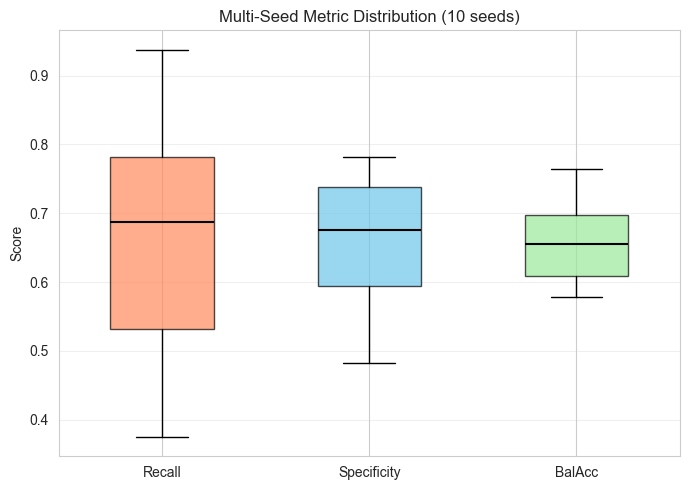

In [52]:
# === Multi-Seed Robustness Check (반대쪽 하한 필터 ≥ 0.3) ===
seeds = list(range(0, 100, 10))  # [0, 10, 20, ..., 90]
MIN_OPP = 0.3  # 반대쪽 지표 하한
target_col = 'Pass/Fail'
X_all = df.drop(columns=[target_col])
y_all = df[target_col].astype(int)

multi_seed_results = []

for seed in seeds:
    # 1. Split (70/15/15)
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
        X_all, y_all, test_size=0.30, random_state=seed, stratify=y_all)
    X_va, X_te, y_va, y_te = train_test_split(
        X_tmp, y_tmp, test_size=0.50, random_state=seed, stratify=y_tmp)

    # 2. ANOVA k=20 (Train only)
    anova_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('anova', SelectKBest(score_func=f_classif, k=20))
    ])
    anova_pipe.fit(X_tr, y_tr)
    sel = X_tr.columns[anova_pipe.named_steps['anova'].get_support()]
    X_tr, X_va, X_te = X_tr[sel], X_va[sel], X_te[sel]

    # 3. 15개 모델 학습
    sampling = OrderedDict([
        ('Baseline', None),
        ('Under',  RandomUnderSampler(random_state=seed)),
        ('SMOTE',  SMOTE(random_state=seed)),
    ])

    res_15 = []
    mdls = {}
    for sn, sampler in sampling.items():
        if sampler is not None:
            imp = SimpleImputer(strategy='median')
            Xs = pd.DataFrame(imp.fit_transform(X_tr), columns=X_tr.columns)
            Xs, ys = sampler.fit_resample(Xs, y_tr)
        else:
            Xs, ys = X_tr.copy(), y_tr.copy()
        for mn, mt in models_def.items():
            m = clone(mt)
            combo = f'{sn}_{mn}'
            r, _ = eval_model(combo, m, Xs, ys, X_va, y_va)
            r['BalAcc'] = (r['Recall'] + r['Specificity']) / 2
            res_15.append(r)
            mdls[combo] = m

    df_r = pd.DataFrame(res_15)

    # 4. Top 3 선택 (반대쪽 하한 필터)
    # Recall 1위: Spec >= MIN_OPP 인 모델 중
    pool_rec = df_r[df_r['Specificity'] >= MIN_OPP]
    pr = pool_rec.sort_values('Recall', ascending=False).iloc[0]['model']
    # Spec 1위: Recall >= MIN_OPP 인 모델 중
    pool_spc = df_r[df_r['Recall'] >= MIN_OPP]
    if len(pool_spc) > 0:
        ps = pool_spc.sort_values('Specificity', ascending=False).iloc[0]['model']
    else:
        ps = df_r.sort_values('BalAcc', ascending=False).iloc[0]['model']
    # BalAcc 1위
    pb = df_r.sort_values('BalAcc', ascending=False).iloc[0]['model']

    picks = list(dict.fromkeys([pr, ps, pb]))
    if len(picks) < 3:
        for _, row in df_r.sort_values('BalAcc', ascending=False).iterrows():
            if row['model'] not in picks:
                picks.append(row['model'])
            if len(picks) == 3:
                break

    # 5. Soft Voting — 가중치 × threshold 탐색
    def sv(names, md, X, w=None):
        return np.average([md[n].predict_proba(X)[:, 1] for n in names], axis=0, weights=w)

    wc = OrderedDict([
        ('균등', None),
        ('[2,1,1]', [2,1,1]), ('[1,2,1]', [1,2,1]), ('[1,1,2]', [1,1,2]),
        ('[3,1,1]', [3,1,1]), ('[1,3,1]', [1,3,1]), ('[1,1,3]', [1,1,3]),
        ('[2,2,1]', [2,2,1]), ('[2,1,2]', [2,1,2]), ('[1,2,2]', [1,2,2]),
        ('[3,2,1]', [3,2,1]), ('[3,1,2]', [3,1,2]), ('[2,3,1]', [2,3,1]),
        ('[1,3,2]', [1,3,2]), ('[2,1,3]', [2,1,3]), ('[1,2,3]', [1,2,3]),
        ('[4,1,1]', [4,1,1]), ('[1,4,1]', [1,4,1]), ('[1,1,4]', [1,1,4]),
        ('[3,3,1]', [3,3,1]), ('[3,1,3]', [3,1,3]), ('[1,3,3]', [1,3,3]),
        ('[5,1,1]', [5,1,1]), ('[1,5,1]', [1,5,1]), ('[1,1,5]', [1,1,5]),
        ('[2,2,2]', [2,2,2]),
    ])
    thrs = np.linspace(0.05, 0.95, 91)
    best_ba, best_t, best_wn, best_wv = 0, 0.5, '균등', None

    for wn, wv in wc.items():
        pva = sv(picks, mdls, X_va, wv)
        for t in thrs:
            pred = (pva >= t).astype(int)
            cm = confusion_matrix(y_va, pred)
            tn, fp, fn, tp = cm.ravel()
            rc = tp/(tp+fn) if (tp+fn) > 0 else 0
            sp = tn/(tn+fp) if (tn+fp) > 0 else 0
            ba = (rc + sp) / 2
            if ba > best_ba:
                best_ba, best_t, best_wn, best_wv = ba, t, wn, wv

    # 6. Test 평가
    pte = sv(picks, mdls, X_te, best_wv)
    pred_te = (pte >= best_t).astype(int)
    cm_te = confusion_matrix(y_te, pred_te)
    tn, fp, fn, tp = cm_te.ravel()
    rec_te = recall_score(y_te, pred_te, zero_division=0)
    spc_te = tn/(tn+fp) if (tn+fp) > 0 else 0

    multi_seed_results.append({
        'seed': seed, 'models': picks, 'weights': best_wn,
        'threshold': best_t, 'Valid_BalAcc': best_ba,
        'Test_PR-AUC': average_precision_score(y_te, pte),
        'Test_Recall': rec_te, 'Test_Specificity': spc_te,
        'Test_BalAcc': (rec_te + spc_te) / 2,
        'Test_Precision': precision_score(y_te, pred_te, zero_division=0),
        'Test_F1': f1_score(y_te, pred_te, zero_division=0),
    })
    print(f'  Seed {seed:>4d}  V={best_ba:.3f} → T={(rec_te+spc_te)/2:.3f}  '
          f'Rec={rec_te:.3f}  Spec={spc_te:.3f}  '
          f'[{best_wn:>7s}] thr={best_t:.2f}')

df_multi = pd.DataFrame(multi_seed_results)

print()
print('=' * 70)
print('  Multi-Seed Summary (반대쪽 하한 필터 ≥ 0.3)')
print('=' * 70)
cols = ['Test_Recall', 'Test_Specificity', 'Test_BalAcc']
for col in cols:
    v = df_multi[col]
    print(f'  {col:20s}: {v.mean():.4f} ± {v.std():.4f}  '
          f'(min={v.min():.4f}, max={v.max():.4f})')
print('=' * 70)

gap = df_multi['Valid_BalAcc'] - df_multi['Test_BalAcc']
print(f'  Valid-Test BalAcc gap: {gap.mean():.4f} ± {gap.std():.4f}')

all_picks = [m for ms in df_multi['models'] for m in ms]
print(f'\n  모델 선택 빈도 (총 {len(all_picks)}회):')
for name, cnt in Counter(all_picks).most_common():
    print(f'    {name}: {cnt}회')


# === 시각화 ===
fig, ax = plt.subplots(figsize=(7, 5))

# 1) Box Plot — Recall, Specificity, BalAcc 분포
box_data = df_multi[['Test_Recall', 'Test_Specificity', 'Test_BalAcc']]
box_data.columns = ['Recall', 'Specificity', 'BalAcc']
bp = ax.boxplot(
    [box_data[c] for c in box_data.columns],
    labels=box_data.columns,
    patch_artist=True,
    widths=0.5,
    medianprops=dict(color='black', linewidth=1.5)
)
colors = ['#FF8A5B', '#6EC5E9', '#9BE89B']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Score')
ax.set_title('Multi-Seed Metric Distribution (10 seeds)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()